This notebook contains code to produce figures in Sanchez et al. 2023 "Relative roles of plume and coastal forcing on exchange
flow variability of a glacial fjord"

In order to generate all the figures, the code must be run in order. Some datasets are used more than once, but only loaded once. Note that NI refers to No Ice, what the paper refers to as NG. IP refers to Ice Plume and what the paper refers to as With Glacier. Figure 8 accidently has one wrong section saved (WG July), we are working on fixing this.

In [96]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import warnings
import matplotlib.dates as mdates
import matplotlib
from os.path import dirname, join as pjoin
import scipy.io as sio
import pandas as pda
import gsw #this is the TEOS-10 library
import datetime as dt
import numpy.matlib as matlib
from scipy.fft import rfft, irfft
from scipy.interpolate import RectBivariateSpline

path_for_data = 'data_for_figs'

## Functions for plots

In [10]:
def low_pass_xarray(cutoff,order,data):
    from scipy import signal
# Define high-pass filter parameters
    cutoff_frequency = cutoff  # Cutoff frequency in normalized frequency units

    # Convert xarray dataset to a numpy array
    data_array = data.values

    # Apply low-pass filtering using Butterworth filter
    b, a = signal.butter(order, cutoff_frequency, btype='low', analog=False, output='ba',fs=1)
    filtered_data = signal.filtfilt(b, a, data_array,axis=0)

    # Convert the filtered numpy array back to xarray dataset
    filtered_data_xr = xr.DataArray(filtered_data, dims='T', coords={'T': data.T})
    return filtered_data_xr

#Fig 12 functions to make plot nonlinear
def forward(x):
    return x**(1/5)

def inverse(x):
    return x**(5)

def convert_rho_z(rho):
    top = 1027.6
    bot = 1024.7
    Z = (top-rho)**(1/2)/((top-bot)**(1/2))
    return Z

def inverse_convert(norm):
    top = 1027.6
    bot = 1024.7
    rho = top-(norm*(top-bot)**(1/2))**(2)
    return rho



#for fig 14
def demean(x):
    return x - x.mean()

def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'same') / n


## Figure 1

In [6]:
#grid for the map
grid =xr.open_dataset(path_for_data +'Fig1/grid.nc')
# the lines used in the section
line_x = [(321.83,322.101),(321.893,322.115),(321.941,322.268),(321.99,322.25),(322.004,322.442),(322.087,322.553),(322.261,322.678)] #lons of the lines
line_y = [(65.65,65.65),(65.77,65.77),(65.897,65.897),(66.0052,66.0052),(66.09,66.09),(66.1627,66.1627),(66.2515,66.2515)]#lats of the lines

#locations of moorings
cm0_lat =65+57.432/60
cm0_lon = 322.22 #360-(37+43.643/60)
sf4_lat = 65+52.256/60
sf4_lon = 360-(37+54.214/60)
sf6_lat = 65+30.331/60
sf6_lon = 360-(37+57.824/60)
ow1_lat = 65+33.906/60
ow1_lon = 360 - (38+21.026/60)
cm6_lat = 65+30.33/60
cm6_lon = 360-(37+57.99/60)

sx = grid.X.sel(X=322.249,method='nearest')
sy = grid.Y.sel(Y=65.48,method='nearest')
grid_SF =grid.sel(Y=slice(65.65,66.2557),X=slice(321.551,322.634)) #take a subsection of the grid from the mouth to island


# load in the CTD data to plot its locations
CTD_dir = pjoin(path_for_data,'Fig1') #path to data files

#2015 data
mat_fname_sf15ctd = pjoin(CTD_dir,'SF2015CTD_allvariables.mat') #file containting ctd profiles from 2010
CTD15m = sio.loadmat(mat_fname_sf15ctd) #read in the struct as a dictionary

#convert from matlab datenum to pandas datenum
new_date = CTD15m['ctddate'][:,0]-719529 
new_date[26] = new_date[27] #fix a broken date
timestamps15 = pda.to_datetime(new_date, unit='D').round('s')


CTD15  = xr.Dataset(
    data_vars= dict(
        temp=(['depth','cast_num'],CTD15m['temp'][:]),# In this case, we have only one cast
        sal=(['depth','cast_num'],gsw.SA_from_SP(CTD15m['sal'][:],CTD15m['pres'][:],CTD15m['ctdlon'][0,0],CTD15m['ctdlat'][0,0])),
    ),
    coords=dict(
        lat=(['cast_num'],CTD15m['ctdlat'][:,0]), 
        lon=(['cast_num'],360+CTD15m['ctdlon'][:,0]),
        dtnum =(['cast_num'],timestamps15),
        depth=-1*CTD15m['depth'][:,0],
        cast_num=np.arange(33)+1,# if you have more than one cast this should be something like np.arange(num of casts)
    ),
    attrs={'description':"2015 CTD Profile", 'temp units':'deg C', 'sal units': 'g/kg', 'depth units': 'm'}
)




#2017 data
mat_fname_sf17ctd = pjoin(CTD_dir,'SF2017CTD.mat') #file containting ctd profiles from 2010
CTD17m = sio.loadmat(mat_fname_sf17ctd) #read in the struct as a dictionary

#convert from matlab datenum to pandas datenum
new_date17 = CTD17m['ctddate'][0,:]-719529 
#new_date[26] = new_date[27] #fix a broken date
timestamps17 = pda.to_datetime(new_date17, unit='D').round('s')



CTD17  = xr.Dataset(
    data_vars= dict(
        temp=(['depth','cast_num'],CTD17m['temp'][:]),# In this case, we have only one cast
        sal=(['depth','cast_num'],gsw.SA_from_SP(CTD17m['sal'][:],CTD17m['pres'][:],CTD17m['ctdlon'][0,0],CTD17m['ctdlat'][0,0])),
    ),
    coords=dict(
        lat=(['cast_num'],CTD17m['ctdlat'][0,:]), 
        lon=(['cast_num'],360+CTD17m['ctdlon'][0,:]),
        dtnum =(['cast_num'],timestamps17),
        depth=-1*CTD17m['depth'][:,0],
        cast_num=np.arange(31)+1,# if you have more than one cast this should be something like np.arange(num of casts)
    ),
    attrs={'description':"2017 CTD Profile", 'temp units':'deg C', 'sal units': 'g/kg', 'depth units': 'm'}
)


mat_fname_sf10ctd = pjoin(CTD_dir,'winter_SF.mat') #file containting ctd profiles from 2010
#file containting ctd profiles from 2010
CTD10m = sio.loadmat(mat_fname_sf10ctd) #read in the struct as a dictionary


CTD10 = xr.Dataset(
    data_vars= dict(
        temp=(['depth'],CTD10m['theta'][:,0]),# In this case, we have only one cast
        sal=(['depth'],gsw.SA_from_SP(CTD10m['salt'][:,0],CTD10m['pres'][0,:],CTD10m['lon'][0][0],CTD10m['lat'][0][0])),
    ),
    coords=dict(
        lat=CTD10m['lat'][0][0], 
        lon=360+CTD10m['lon'][0][0],
        depth=gsw.z_from_p(CTD10m['pres'][0,:],CTD10m['lat'][0][0]),
        #cast_num=1,# if you have more than one cast this should be something like np.arange(num of casts)
    ),
    attrs={'description':"2010 CTD Profile", 'temp units':'deg C', 'sal units': 'g/kg', 'depth units': 'm'}
)


<Figure size 640x480 with 0 Axes>

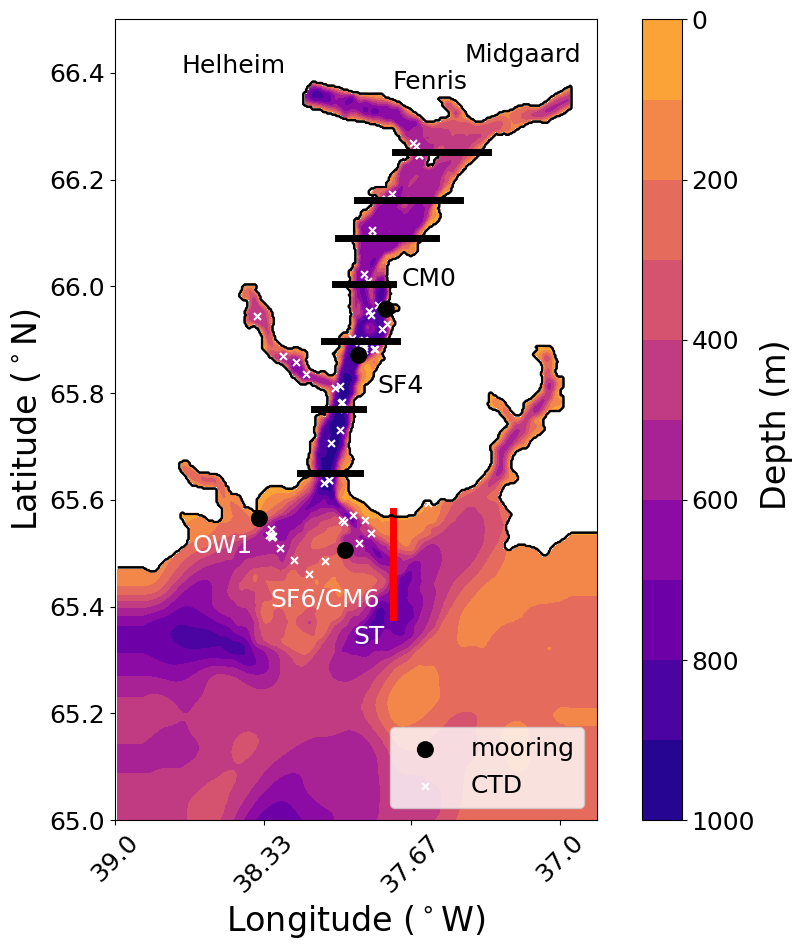

In [36]:
%matplotlib inline
s = 1.2 #a scale factor for the figure
plt.figure()
fig, (ax3) = plt.subplots(nrows=1,ncols=1,figsize=(8*s,8*s))


#plot bathymetry
im3 = ax3.contourf(grid.X,grid.Y,grid.Depth,cmap='plasma_r',levels=10,vmin=-200,vmax=1000)
#plot section lines
ax3.plot(line_x[0],line_y[0],'k',linewidth=5,zorder=10)
ax3.plot(line_x[1],line_y[1],'k',linewidth=5,zorder=10)
ax3.plot(line_x[2],line_y[2],'k',linewidth=5,zorder=10)
ax3.plot(line_x[3],line_y[3],'k',linewidth=5,zorder=10)
ax3.plot(line_x[4],line_y[4],'k',linewidth=5,zorder=10)
ax3.plot(line_x[5],line_y[5],'k',linewidth=5,zorder=10)
ax3.plot(line_x[6],line_y[6],'k',linewidth=5,zorder=10)
#plot shelf line
ax3.plot([322.25,322.25],[65.38,65.58],linewidth=5,color='r')
ax3.text(322.07,65.33, 'ST', color='w',fontsize=18)
#plot glaciers
ax3.text(321.3,66.4,'Helheim',color='black',fontsize=18)
ax3.text(322.25,66.37,'Fenris',color='black',fontsize=18)
ax3.text(322.57,66.42,'Midgaard',color='black',fontsize=18)
#plot background
ax3.pcolor(grid.X,grid.Y,grid.Depth.where(grid.Depth <1),color='white',shading='auto')
#plot contour of coast
ax3.contour(grid.X,grid.Y,grid.Depth,levels=[0,10],colors='k',zorder=10)
ax3.set_xlabel('Longitude ($^\circ$W)',fontsize=24)
ax3.set_ylabel('Latitude ($^\circ$N)',fontsize=24)
#plot locations of moorings
ax3.scatter(cm0_lon,cm0_lat,s=150,c='k',marker='o', edgecolor='none',label='mooring', zorder=10)
ax3.text(322.29,66,'CM0', color='k',fontsize=18,zorder=25)
ax3.scatter(sf4_lon,sf4_lat,s=150,c='k',marker='o', edgecolor='none',zorder=10)
ax3.text(322.178,65.8,'SF4',color='k',fontsize=18)
ax3.scatter(sf6_lon,sf6_lat,s=150,c='k',marker='o', edgecolor='none',zorder=10)
ax3.text(321.7,65.4,'SF6/CM6',color='w',fontsize=18,zorder=10)
ax3.scatter(ow1_lon,ow1_lat,s=150,c='k',marker='o', edgecolor='none',zorder=10)
ax3.text(321.35,65.5,'OW1',color='w',fontsize=18,zorder=10)
#plot CTD locations
ax3.scatter(CTD15.lon,CTD15.lat,s=25,c='w',marker='x', label='CTD',zorder=1)
ax3.scatter(CTD17.lon,CTD17.lat,s=25,c='w',marker='x',zorder=1)
ax3.legend(loc='lower right',frameon=True,fontsize=18)
ax3.set_ylim(64.8,66.6)
ax3.tick_params('both', labelsize=14)
cbar = fig.colorbar(im3, ax=ax3, orientation='vertical')        
cbar.ax.set_ylabel('Depth (m) ', rotation=90, fontsize='24')
cbar.ax.yaxis.set_tick_params(labelsize=18)
cbar.ax.invert_yaxis() 
#axis labels
xticks = np.around(np.linspace(321,323,4),2)
xtick_labels = [str(x) for x in abs(np.round(xticks-360,2)).tolist()]

ax3.set_ylim([65,66.5])
ax3.tick_params(axis='y', labelsize=18)
ax3.tick_params(axis='x', rotation=45,labelsize=18)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xtick_labels)
ax3.set_aspect(2.4)
fig.tight_layout()
plt.savefig('Figs/fjord_map_sections.png')

## Figure 2
Figure 2 was primarily composed by a co-author in MATLAB and is unavailable. However, the CTD data is located in Figure 1. And the model output came from section 1 of the TEF.

## Figure 3

In [57]:
#load TEF timeseries for timestamps
#(we will use this xarray in future plots)
bulk_vol_d_ni = xr.open_dataset(path_for_data+'Fig11/bulk_vol_d_ni.nc')

#load runoff
Qsg = xr.open_dataset(path_for_data+'Fig3/runoff_forcing.nc')
Qsg_total = Qsg.QM+Qsg.QF+Qsg.QH
Qsg['Qsg'] = Qsg.QH+Qsg.QM+Qsg.QF
SF_Qsg_l = Qsg_total.rolling(time=30,center=True).mean() 

#load surface wind
surf = xr.open_dataset(path_for_data+'Fig3/surf.nc')
tau_lp = -low_pass_xarray(.01,6,surf.shelf_x)
dtau_lp_dx = tau_lp.diff('T')

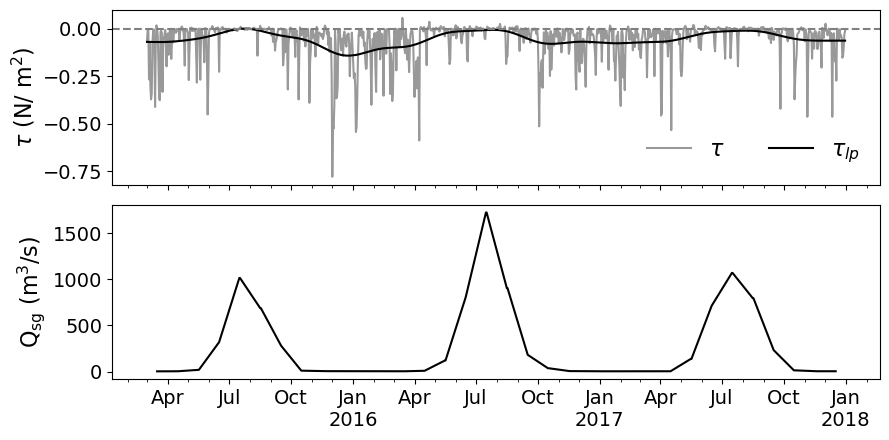

In [12]:
a = 15 #cutoff the ends of the rolling mean
b = -15
s = 9/8

tkw = dict(size=4, width=1.5)
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(8*s,4*s))
#plot wind
ax1.plot(surf.T,-surf.shelf_x,'k',alpha=.4,label=r'$\tau$')
ax1.plot(surf.T,tau_lp,'k',label=r'$\tau_{lp}$')
ax1.axhline(y = 0, color = 'gray', linestyle = '--')
ax1.set_ylabel(r'$\tau$ (N/ m$^2$)',fontsize=16)
ax1.legend(frameon=False,loc='lower right',fontsize=16,ncol=2)
#plot discharge
ax2.plot(bulk_vol_d_ni.time[a:b],SF_Qsg_l[a:b],color='k')
ax2.set_ylabel('Q$_{\mathrm{sg}}$ (m$^{3}$/s)',fontsize=16)

ax1.tick_params('y', labelsize=14)
ax2.tick_params('y', labelsize=14)
ax2.tick_params('x', labelsize=14)
ax2.tick_params('y', labelsize=14)
locator = mdates.MonthLocator(bymonth=np.arange(1,12,3))
ax2.xaxis.set_major_locator(locator)
min_loc = mdates.MonthLocator()
ax2.xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

formatter = mdates.ConciseDateFormatter(locator, zero_formats=zfmts, show_offset=False)
ax2.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('Figs/winds_and_discharge.png')

## Figure 4

In [14]:
sst_ds =xr.open_dataset('figures/sst_map.nc')
#March 2017

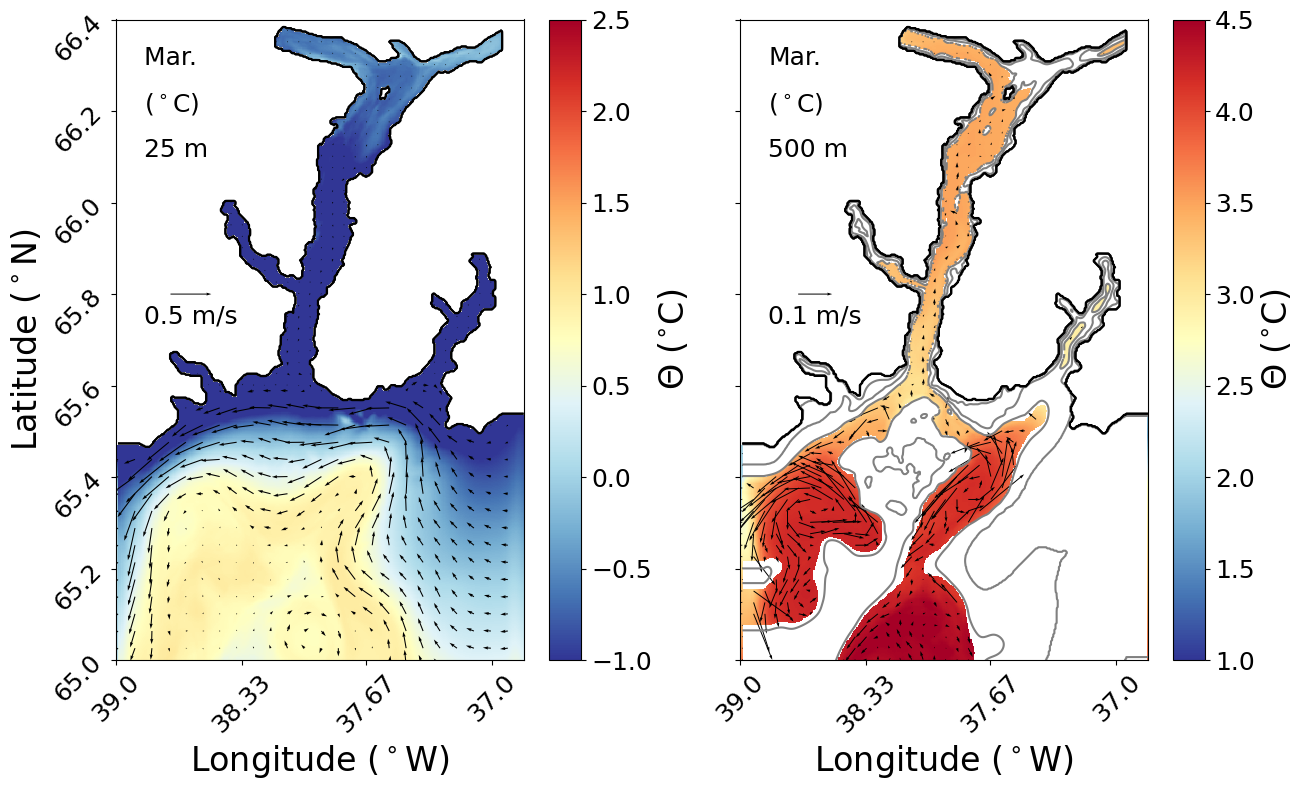

In [17]:
n2 = 15
n1 = 10 #spacing for quiver plots
s=1
r = 1.65

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(8*s*r,8*s))

#25 m temp and vel

im1 = ax1.pcolor(sst_ds.X,sst_ds.Y,sst_ds.temp_25,cmap='RdYlBu_r',vmin=-1,vmax=2.5,shading='auto') #temp plot
QV1 = ax1.quiver(sst_ds.X[::n1],sst_ds.Y[320::n1],sst_ds.U_25[320::n1, ::n1], sst_ds.V_25[320::n1,::n1], scale=5,color='black')
ax1.quiver(sst_ds.X[::n2],sst_ds.Y[:320:n2],sst_ds.U_25[:320:n2, ::n2], sst_ds.V_25[:320:n2,::n2], scale=5,color='black')
cbar = fig.colorbar(im1, ax=ax1, orientation='vertical')
cbar.ax.set_ylabel('$\Theta$ ($^{\circ}$C)', rotation=90, fontsize='24')
cbar.ax.yaxis.set_tick_params(labelsize=18)


#plot bathy background
ax1.pcolor(sst_ds.X,sst_ds.Y,sst_ds.Depth.where(sst_ds.Depth <1),color='white',shading='auto')
ax1.contour(sst_ds.X,sst_ds.Y,sst_ds.Depth,levels=[0,10],colors='k',zorder=10)#coast line

#plot text
ax1.text(321.15,66.3,'Mar. ',color='k',fontsize=18)
ax1.text(321.15,66.2,'($^\circ$C)',color='k',fontsize=18)
ax1.text(321.15,66.1,'25 m',color='k',fontsize=18)
ax1.quiverkey(QV1, 321.4,65.8, .5, '0.5 m/s', labelpos='S',coordinates='data',fontproperties={"size":18})

#axis labels


xticks = np.around(np.linspace(321,323,4),2)
xtick_labels = [str(x) for x in abs(np.round(xticks-360,2)).tolist()]

ax1.tick_params(axis='x', rotation=45,labelsize=18)
ax1.tick_params(axis='y', rotation=45,labelsize=18)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xtick_labels)
ax1.set_xlabel('Longitude ($^\circ$W)',fontsize=24)
ax1.set_ylabel('Latitude ($^\circ$N)',fontsize=24)
ax1.set_ylim([65,66.4])

#500 m temp and vel

im1 = ax2.pcolor(sst_ds.X,sst_ds.Y,sst_ds.temp_500,cmap='RdYlBu_r',vmin=1,vmax=4.5,shading='auto')
QV2 = ax2.quiver(sst_ds.X[::n1],sst_ds.Y[320::n1],sst_ds.U_500[320::n1, ::n1], sst_ds.V_500[320::n1,::n1], scale=1.2,color='black')
ax2.quiver(sst_ds.X[::n1],sst_ds.Y[:320:n1],sst_ds.U_500[:320:n1, ::n1], sst_ds.V_500[:320:n1,::n1], scale=1.2,color='black')
cbar = fig.colorbar(im1, ax=ax2, orientation='vertical')
cbar.ax.set_ylabel('$\Theta$ ($^{\circ}$C)', rotation=90, fontsize='24')
cbar.ax.yaxis.set_tick_params(labelsize=18)


#plot bathy background
ax2.contour(sst_ds.X,sst_ds.Y,sst_ds.Depth.where(sst_ds.Depth <500),levels=[100,250,450],colors='gray')
ax2.pcolor(sst_ds.X,sst_ds.Y,sst_ds.Depth.where(sst_ds.Depth <1),color='white',shading='auto')
ax2.contour(sst_ds.X,sst_ds.Y,sst_ds.Depth,levels=[0,10],colors='k',zorder=10)

#plot text
ax2.quiverkey(QV2, 321.4,65.8, .1, '0.1 m/s', labelpos='S',coordinates='data',fontproperties={"size":18})
ax2.text(321.15,66.3,'Mar.',color='k',fontsize=18)
ax2.text(321.15,66.2,'($^\circ$C)',color='k',fontsize=18)
ax2.text(321.15,66.1,'500 m',color='k',fontsize=18)


#axis labels
xticks = np.around(np.linspace(321,323,4),2)
xtick_labels = [str(x) for x in abs(np.round(xticks-360,2)).tolist()]



ax2.tick_params(axis='x', rotation=45,labelsize=18)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xtick_labels)
ax2.set_xlabel('Longitude ($^\circ$W)',fontsize=24)
ax2.set_ylim([65,66.4])
plt.tight_layout()


## Figure 5

In [27]:
# Create lists of temperature, salinity and velocity for the shelf sections
base_path = path_for_data+'/Fig5/shelf/'
for i in range(1,13):
    s_path = base_path+'salt_'+str(i)+'_ni.nc'
    temp_path = base_path+'temp_'+str(i)+'_ni.nc'
    u_path = base_path+'u_'+str(i)+'_ni.nc'
    S_var = f"Salt_{i}"
    Temp_var = f"Temp_{i}"
    u_var = f"U_{i}"
    exec(f"{S_var} = xr.open_dataarray('{s_path}')")
    exec(f"{Temp_var} = xr.open_dataarray('{temp_path}')")
    exec(f"{u_var} = xr.open_dataarray('{u_path}')")

temp_list = [[Temp_1,Temp_2],[Temp_3,Temp_4],[Temp_5,Temp_6],[Temp_7,Temp_8],[Temp_9,Temp_10],[Temp_11,Temp_12]]
salt_list= [[Salt_1,Salt_2],[Salt_3,Salt_4],[Salt_5,Salt_6],[Salt_7,Salt_8],[Salt_9,Salt_10],[Salt_11,Salt_12]]
U_list= [[U_1,U_2],[U_3,U_4],[U_5,U_6],[U_7,U_8],[U_9,U_10],[U_11,U_12]]

Xpt = grid.X[208].values #location of the line on the shelf
bathy_outline = grid.Depth.sel(X=Xpt,Y=slice(65.38,65.58))

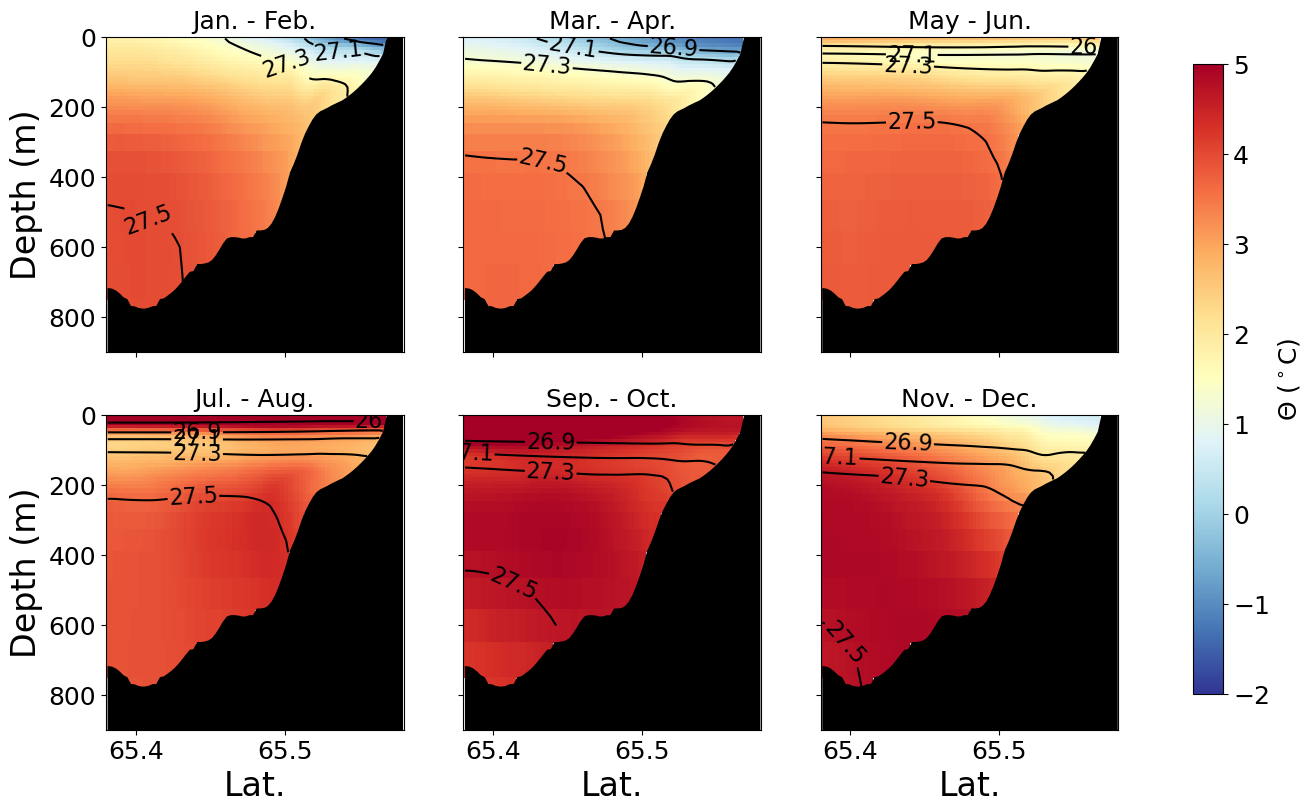

In [26]:
## 6 month panel
title_list = [['Jan. - Feb.','Mar. - Apr.','May - Jun.'],['Jul. - Aug.','Sep. - Oct.','Nov. - Dec.']]
color_list = [['k','k','k'],['k','k','k']]
month_list = [[31,28],[31,30],[31,30],[31,31],[30,31],[30,31]]


s = 1.5
fig, (ax) = plt.subplots(nrows=2,ncols=3,sharey=True,sharex=True,figsize=(10*s, 6*s))
k = -1


for i in range(2):
    for j in range(3):
        if i == 1:
            #set xlabel
            ax[i,j].set_xlabel('Lat.', fontsize=24)
        if j == 0:
            #set ylabel
            ax[i,j].set_ylabel('Depth (m)', fontsize=24)
        k += 1
        #get the number of time points in each section
        N = month_list[k][0]+month_list[k][1]
        #calculate average temp,salinity and density for the contours
        temp_i = temp_list[k][0]*month_list[k][0]/N+ temp_list[k][1]*month_list[k][1]/N
        salt_i = salt_list[k][0]*month_list[k][0]/N+ salt_list[k][1]*month_list[k][1]/N
        rho_i = gsw.rho(salt_i,temp_i,0)-1000
        #plot average temp
        im1 = ax[i,j].pcolor(grid.Y.sel(Y=slice(65.38,65.58)),-grid.Z,temp_i, cmap='RdYlBu_r',vmin=-2,vmax=5,shading='auto')
        #plot bathy
        ax[i,j].fill_between(grid.Y.sel(Y=slice(65.38,65.58)),bathy_outline,1000, color='k')
        #plot density contours
        CS1 = ax[i,j].contour(grid.Y.sel(Y=slice(65.38,65.58)),-grid.Z,rho_i,levels=[24,25,26.5,26.9,27.1,27.3,27.5],colors='k')
        fmt = {}
        strs = ['24','25','26.5','26.9','27.1','27.3','27.5']# labels added to the contours
        for l,s in zip(CS1.levels,strs):
            fmt[l] = s
        #label the levels with strings
        ax[i,j].clabel(CS1,levels=CS1.levels,fmt=fmt,fontsize=16)
        ax[i,j].set_ylim(900,0)
        ax[i,j].set_title(title_list[i][j],color=color_list[i][j],fontsize=18)
        ax[i,j].tick_params('both', labelsize=18)
        

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#plt.tight_layout()
cb = fig.colorbar(im1, cax=cbar_ax,label='$\Theta$ ($^\circ$C)')
cb.ax.tick_params(labelsize=18)
text = cb.ax.yaxis.label
font = matplotlib.font_manager.FontProperties( size=18)
text.set_font_properties(font)
plt.savefig('Figs/shelf_temp.png')        

## Figure 6

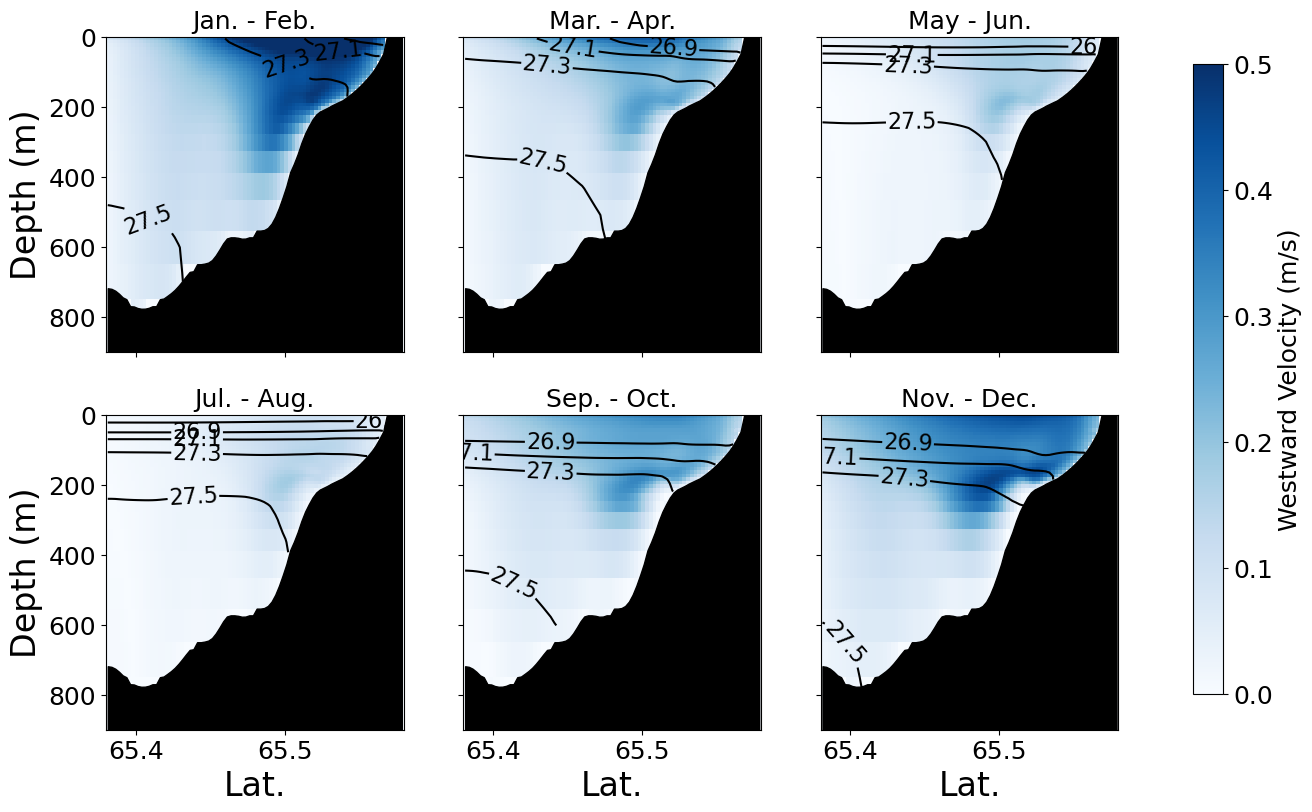

In [28]:
title_list = [['Jan. - Feb.','Mar. - Apr.','May - Jun.'],['Jul. - Aug.','Sep. - Oct.','Nov. - Dec.']]
color_list = [['k','k','k'],['k','k','k']]
month_list = [[31,28],[31,30],[31,30],[31,31],[30,31],[30,31]]


s = 1.5
fig, (ax) = plt.subplots(nrows=2,ncols=3,sharey=True,sharex=True,figsize=(10*s, 6*s))
k = -1





for i in range(2):
    for j in range(3):
        if i == 1:
            ax[i,j].set_xlabel('Lat.', fontsize=24)
        if j == 0:
            ax[i,j].set_ylabel('Depth (m)', fontsize=24)
        k += 1
        #get the number of time points in each section
        N = month_list[k][0]+month_list[k][1]
        #calculate average temp,salinity and density for the contours
        temp_i = temp_list[k][0]*month_list[k][0]/N+ temp_list[k][1]*month_list[k][1]/N
        salt_i = salt_list[k][0]*month_list[k][0]/N+ salt_list[k][1]*month_list[k][1]/N
        u_i = U_list[k][0]*month_list[k][0]/N+ U_list[k][1]*month_list[k][1]/N
        rho_i = gsw.rho(salt_i,temp_i,0)-1000
        #plot velocity
        im1 = ax[i,j].pcolor(grid.Y.sel(Y=slice(65.38,65.58)),-grid.Z,abs(u_i), cmap='Blues',vmin=0,vmax=.5,shading='auto')
        #plot bathy
        ax[i,j].fill_between(grid.Y.sel(Y=slice(65.38,65.58)),bathy_outline,1000, color='k')
        #plot contours
        CS1 = ax[i,j].contour(grid.Y.sel(Y=slice(65.38,65.58)),-grid.Z,rho_i,levels=[24,25,26.5,26.9,27.1,27.3,27.5],colors='k')
        fmt = {}
        strs = ['24','25','26.5','26.9','27.1','27.3','27.5']# labels added to the contours
        for l,s in zip(CS1.levels,strs):
            fmt[l] = s
        #label the levels with strings
        ax[i,j].clabel(CS1,levels=CS1.levels,fmt=fmt,fontsize=16)
        #ax[0].clabel(CS1,levels=CS1.levels,fontsize=10)
        ax[i,j].set_ylim(900,0)


        ax[i,j].set_title(title_list[i][j],color=color_list[i][j],fontsize=18)
        ax[i,j].tick_params('both', labelsize=18)
        

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax,label='Westward Velocity (m/s)')
cb.ax.tick_params(labelsize=18)
text = cb.ax.yaxis.label
font = matplotlib.font_manager.FontProperties( size=18)
text.set_font_properties(font)
plt.savefig('Figs/shelf_vel.png')     

## Figure 7

In [61]:
SF3_16_ni = xr.open_dataset(path_for_data+'Fig7/SF3_ni_16.nc') #year long cross-section data
SF3_16_ip = xr.open_dataset(path_for_data+'Fig7SF3_ip_16.nc')

#time periods we will highlight
time4_1 = dt.datetime(2016,4,1)
time5_1 = dt.datetime(2016,5,1)
time7_1 = dt.datetime(2016,7,1)
time8_1 = dt.datetime(2016,8,1)
time11_1 = dt.datetime(2016,11,1)
time12_1 = dt.datetime(2016,12,1)

#bathy for the cross-section
bathy_outline2 = grid.Depth.sel(X=SF3_16_ni.X,Y=SF3_16_ni.Y).mean('Y')
xline = grid.dxF.sel(X=SF3_16_ni.X,Y=SF3_16_ni.Y).mean('Y').cumsum('X')

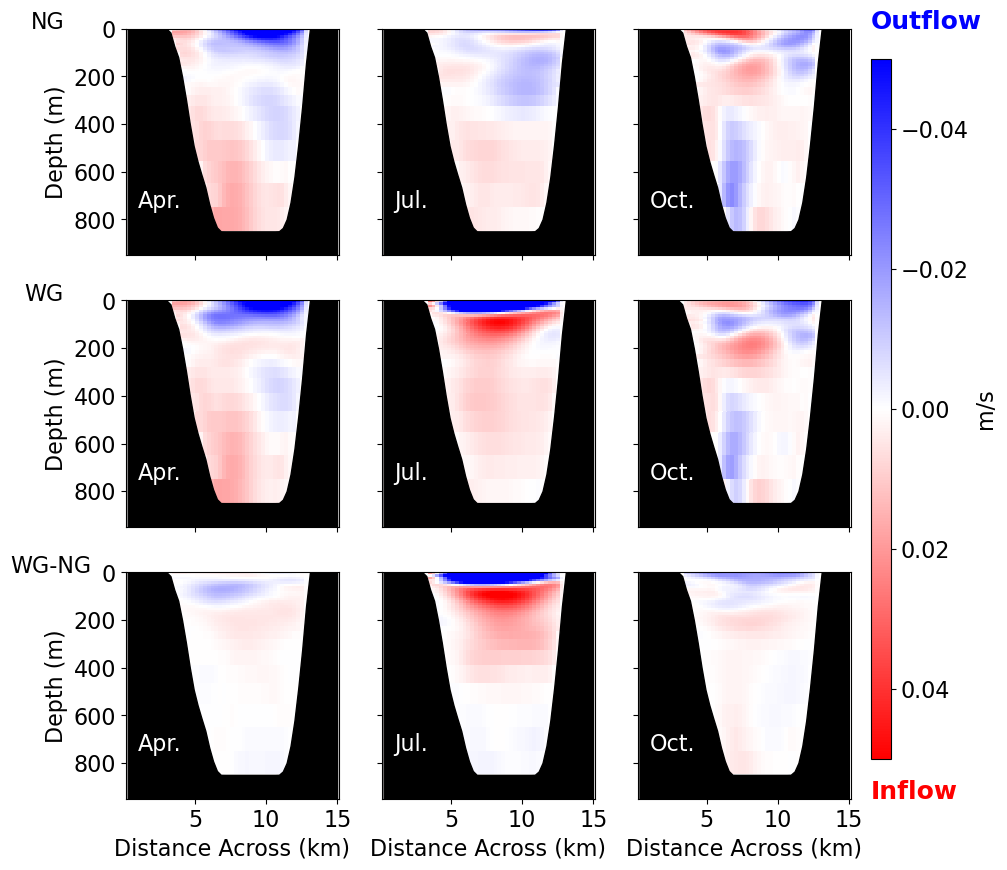

In [35]:
s = .05

fig, ((ax1, ax2, ax3),(ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharey=True,sharex=True)
im1 = ax1.pcolor(xline/1000,-grid.Z,SF3_16_ni.V.sel(T=slice(time4_1,time5_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax1.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax1.text(1,750,'Apr.',fontsize=16,color='white')
ax1.text(-6.5,0,'NG',fontsize=16,color='black')

im2 = ax2.pcolor(xline/1000,-grid.Z,SF3_16_ni.V.sel(T=slice(time7_1,time8_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax2.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax2.text(1,750,'Jul.',fontsize=16,color='white')


im3 = ax3.pcolor(xline/1000,-grid.Z,SF3_16_ni.V.sel(T=slice(time11_1,time12_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax3.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax3.text(1,750,'Oct.',fontsize=16,color='white')
ax3.text(16.5,0,'Outflow',fontsize=18,color='blue',weight="bold")

im4 = ax4.pcolor(xline/1000,-grid.Z,SF3_16_ip.V.sel(T=slice(time4_1,time5_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax4.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax4.text(1,750,'Apr.',fontsize=16,color='white')
ax4.text(-7,0,'WG',fontsize=16,color='black')
ax4.invert_yaxis()

im5 = ax5.pcolor(xline/1000,-grid.Z,SF3_16_ip.V.sel(T=slice(time7_1,time8_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax5.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax5.text(1,750,'Jul.',fontsize=16,color='white')
ax5.invert_yaxis()

im6 = ax6.pcolor(xline/1000,-grid.Z,SF3_16_ip.V.sel(T=slice(time11_1,time12_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax6.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax6.text(1,750,'Oct.',fontsize=16,color='white')
ax6.invert_yaxis()

im7 = ax7.pcolor(xline/1000,-grid.Z,SF3_16_ip.V.sel(T=slice(time4_1,time5_1)).mean(dim=['Yp1','T'])-SF3_16_ni.V.sel(T=slice(time4_1,time5_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax7.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax7.text(1,750,'Apr.',fontsize=16,color='white')
ax7.text(-8,0,'WG-NG',fontsize=16,color='black')
ax7.invert_yaxis()

im8 = ax8.pcolor(xline/1000,-grid.Z,SF3_16_ip.V.sel(T=slice(time7_1,time8_1)).mean(dim=['Yp1','T'])-SF3_16_ni.V.sel(T=slice(time7_1,time8_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax8.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax8.text(1,750,'Jul.',fontsize=16,color='white')
ax8.invert_yaxis()

im9 = ax9.pcolor(xline/1000,-grid.Z,SF3_16_ip.V.sel(T=slice(time11_1,time12_1)).mean(dim=['Yp1','T'])-SF3_16_ni.V.sel(T=slice(time11_1,time12_1)).mean(dim=['Yp1','T']), cmap='bwr', vmin=-s, vmax=s)
ax9.fill_between(xline/1000,bathy_outline2,1000, color='k')
ax9.text(1,750,'Oct.',fontsize=16,color='white')

ax9.text(16.5,950,'Inflow',fontsize=18,color='red',weight="bold")
ax9.invert_yaxis()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([.87, 0.15, 0.02, 0.7])
cb = fig.colorbar(im1, cax=cbar_ax,label='m/s')
cb.ax.tick_params(labelsize=16)
cb.ax.invert_yaxis() 
text = cb.ax.yaxis.label
font = matplotlib.font_manager.FontProperties( size=16)
text.set_font_properties(font)

ax1.tick_params('both', labelsize=16)
ax2.tick_params('both', labelsize=16)
ax3.tick_params('both', labelsize=16)
ax4.tick_params('both', labelsize=16)
ax5.tick_params('both', labelsize=16)
ax6.tick_params('both', labelsize=16)
ax7.tick_params('both', labelsize=16)
ax8.tick_params('both', labelsize=16)
ax9.tick_params('both', labelsize=16)


ax7.set_xlabel('Distance Across (km)',fontsize=16)
ax8.set_xlabel('Distance Across (km)',fontsize=16)
ax9.set_xlabel('Distance Across (km)',fontsize=16)

ax1.set_ylabel('Depth (m)',fontsize=16)
ax4.set_ylabel('Depth (m)',fontsize=16)
ax7.set_ylabel('Depth (m)',fontsize=16)
ax1.set_ylim(950,0)
plt.savefig('Figs/standing_cross.png')

## Figure 8

In [94]:
#load the data arrays used to make sections

da_depth_along = xr.open_dataarray(path_for_data+'/Fig8/da_depth_along.nc')
da_OT_along_ni3 = xr.open_dataarray(path_for_data+'/Fig8/da_OT_along_ni3.nc')
da_OT_along_ni7 = xr.open_dataarray(path_for_data+'/Fig8/da_OT_along_ni7.nc')
da_OT_along_ni10 = xr.open_dataarray(path_for_data+'/Fig8/da_OT_along_ni10.nc')
da_OT_along_ip3 = xr.open_dataarray(path_for_data+'/Fig8/da_OT_along_ip3.nc')
da_OT_along_ip7 = xr.open_dataarray(path_for_data+'/Fig8/da_OT_along_ip7.nc')
da_OT_along_ip10 = xr.open_dataarray(path_for_data+'/Fig8/da_OT_along_ip10.nc')
da_S_along_ni3 = xr.open_dataarray(path_for_data+'/Fig8/da3_S_along.nc')
da_Temp_along_ni3 = xr.open_dataarray(path_for_data+'/Fig8/da3_Temp_along.nc')
da_S_along_ni7 = xr.open_dataarray(path_for_data+'/Fig8/da7_S_along.nc')
da_Temp_along_ni7 = xr.open_dataarray(path_for_data+'/Fig8/da7_Temp_along.nc')
da_S_along_ni10 = xr.open_dataarray(path_for_data+'/Fig8/da10_S_along.nc')
da_Temp_along_ni10 = xr.open_dataarray(path_for_data+'/Fig8/da10_Temp_along.nc')
da_S_along_ip7= xr.open_dataarray(path_for_data+'/Fig8/da7_S_along_ip.nc')
da_Temp_along_ip7 = xr.open_dataarray(path_for_data+'/Fig8/da7_Temp_along_ip.nc')



/var/folders/0_/dtfd77yj0qqgjcbcstn1ktz40000gn/T/ipykernel_57193/144911993.py:8: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  CS1a  = ax1.pcolor(da_Temp_along_ni3.L,-da_Temp_along_ni3.Z, da_Temp_along_ni3, cmap='RdYlBu_r', vmin=-2, vmax=5)
/var/folders/0_/dtfd77yj0qqgjcbcstn1ktz40000gn/T/ipykernel_57193/144911993.py:24: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  CS2a  = ax2.pcolor(da_Temp_along_ni7.L,-da_Temp_along_ni7.Z, da_Temp_along_ni7, cmap='RdYlBu_r', vmin=-2, vmax=5)
/var/folders/0_/dtfd77yj0qqgjcbcstn1ktz40000gn/T/ipykernel_57193/144911993.py:40: UserWarning: The input coordinates to p

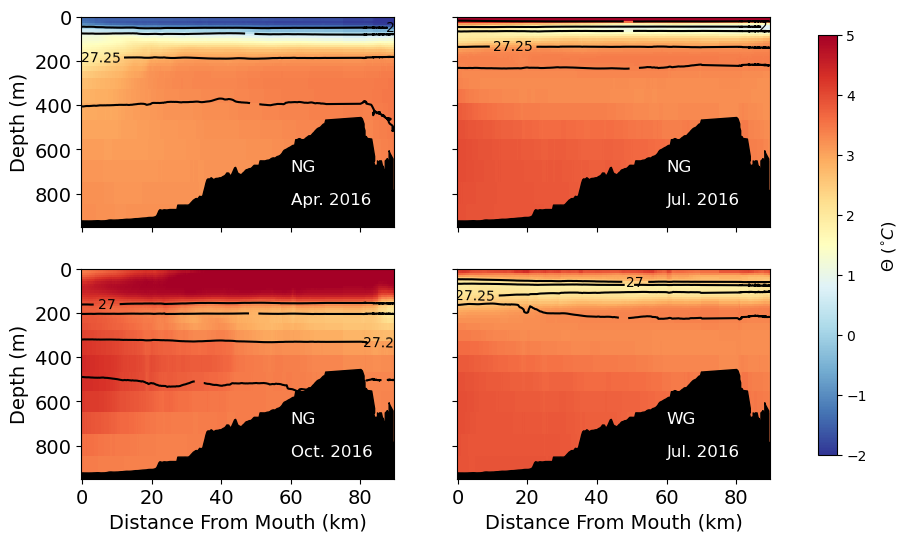

In [95]:
base = 1000*np.ones(len(da_depth_along.L)) #used for bathymetry plot

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(9.5,6), sharex=True,sharey=True)
#march NG
fmt2 = {}
levels2 = [26,26.5,27,27.15,27.35,27.45]
CS1 = ax1.contour(da_Temp_along_ni3.L,-da_Temp_along_ni3.Z,gsw.rho(da_S_along_ni3,da_Temp_along_ni3,0)-1000,levels=levels2,colors='k')
CS1a  = ax1.pcolor(da_Temp_along_ni3.L,-da_Temp_along_ni3.Z, da_Temp_along_ni3, cmap='RdYlBu_r', vmin=-2, vmax=5)

strs2 = ['26','','27','','27.25','','27.45']# labels added to the contours
for l,s in zip(CS1.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax1.clabel(CS1,levels=CS1.levels,fmt=fmt2,fontsize=10)
ax1.fill_between(da_depth_along.L,-da_depth_along,base,color='k')
ax1.set_ylabel('Depth (m)', fontsize=14)
ax1.tick_params('both', labelsize=14)
ax1.text(60,850,'Apr. 2016',fontsize=12,color='white')
ax1.text(60,700,'NG',fontsize=12,color='white')

#july NG
fmt2 = {}
CS2 = ax2.contour(da_Temp_along_ni7.L,-da_Temp_along_ni7.Z,gsw.rho(da_S_along_ni7,da_Temp_along_ni7,0)-1000,levels=levels2,colors='k')
CS2a  = ax2.pcolor(da_Temp_along_ni7.L,-da_Temp_along_ni7.Z, da_Temp_along_ni7, cmap='RdYlBu_r', vmin=-2, vmax=5)


for l,s in zip(CS2.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax2.clabel(CS2,levels=CS2.levels,fmt=fmt2,fontsize=10)
ax2.fill_between(da_depth_along.L,-da_depth_along,base,color='k')

ax2.tick_params('both', labelsize=14)
ax2.text(60,850,'Jul. 2016',fontsize=12,color='white')
ax2.text(60,700,'NG',fontsize=12,color='white')

#oct NG
fmt2 = {}
CS3 = ax3.contour(da_Temp_along_ni10.L,-da_Temp_along_ni10.Z,gsw.rho(da_S_along_ni10,da_Temp_along_ni10,0)-1000,levels=levels2,colors='k')
CS3a  = ax3.pcolor(da_Temp_along_ni10.L,-da_Temp_along_ni10.Z, da_Temp_along_ni10, cmap='RdYlBu_r', vmin=-2, vmax=5)

#strs2 = ['-50','-40','-30','-20','-10','0','10','20','30','40','50']# labels added to the contours
for l,s in zip(CS3.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax3.clabel(CS3,levels=CS3.levels,fmt=fmt2,fontsize=10)
ax3.fill_between(da_depth_along.L,-da_depth_along,base,color='k')
ax3.set_ylabel('Depth (m)', fontsize=14)
ax3.set_xlabel('Distance From Mouth (km)', fontsize=14)
ax3.tick_params('both', labelsize=14)
ax3.text(60,850,'Oct. 2016',fontsize=12,color='white')
ax3.text(60,700,'NG',fontsize=12,color='white')

#july wg
fmt2 = {}
CS4 = ax4.contour(da_Temp_along_ip7.L,-da_Temp_along_ip7.Z,gsw.rho(da_S_along_ip7,da_Temp_along_ip7,0)-1000,levels=levels2,colors='k')
CS4a  = ax4.pcolor(da_Temp_along_ip7.L,-da_Temp_along_ip7.Z, da_Temp_along_ip7, cmap='RdYlBu_r', vmin=-2, vmax=5)
ax4.text(60,850,'Jul. 2016',fontsize=12,color='white')
ax4.text(60,700,'WG',fontsize=12,color='white')

for l,s in zip(CS4.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax4.clabel(CS4,levels=CS4.levels,fmt=fmt2,fontsize=10)
ax4.fill_between(da_depth_along.L,-da_depth_along,base,color='k')
#ax4.set_ylabel('Depth (m)', fontsize=14)
ax4.set_xlabel('Distance From Mouth (km)', fontsize=14)
ax4.tick_params('both', labelsize=14)
ax4.set_ylim([950,0])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS1a, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('$\Theta$ ($^{\circ}C$) ', rotation=90, fontsize='12')

plt.savefig('Figs/stream_temp.png')

## Figure 9

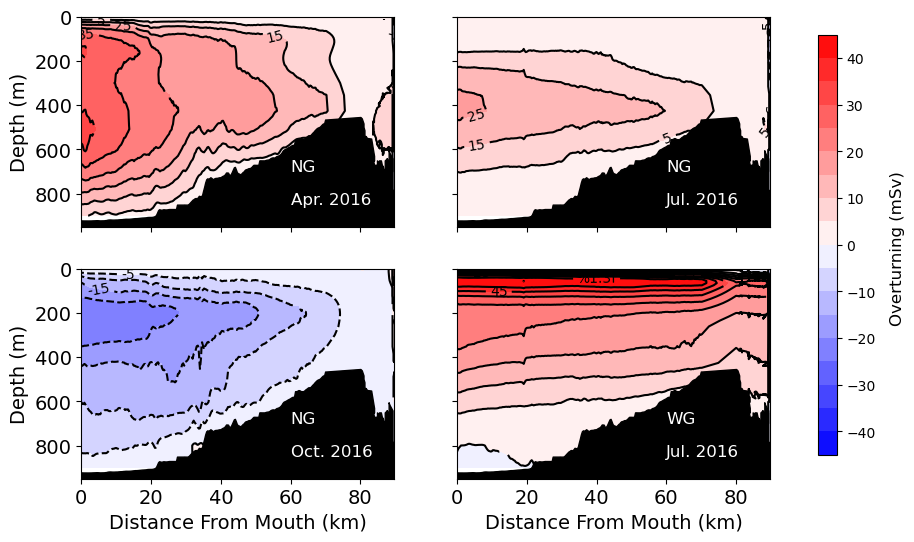

In [91]:

base = 1000*np.ones(len(da_depth_along.L))
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(9.5,6), sharex=True,sharey=True)
fmt2 = {}
levels2 = [-45,-40,-35,-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45]
CS1 = ax1.contour(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ni3/(10**3), levels = levels2, colors='black')
CS1a =  ax1.contourf(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ni3/(10**3), levels = levels2, cmap='bwr')

strs2 = ['-45','','-35','','-25','','-15','','-5','','5','15','25','','35','','45']# labels added to the contours
for l,s in zip(CS1.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax1.clabel(CS1,levels=CS1.levels,fmt=fmt2,fontsize=10)
ax1.fill_between(da_depth_along.L,-da_depth_along,base,color='k')
ax1.set_ylabel('Depth (m)', fontsize=14)
#ax1.set_xlabel('Distance From Mouth (km)', fontsize=14)
ax1.tick_params('both', labelsize=14)
ax1.text(60,850,'Apr. 2016',fontsize=12,color='white')
ax1.text(60,700,'NG',fontsize=12,color='white')
ax1.invert_yaxis()

fmt2 = {}
CS2 = ax2.contour(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ni7/(10**3), levels=levels2, colors='black')
CS2a =  ax2.contourf(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ni7/(10**3), levels=levels2, cmap='bwr')

#strs2 = ['-50','-40','-30','-20','-10','0','10','20','30','40','50']# labels added to the contours
for l,s in zip(CS2.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax2.clabel(CS2,levels=CS2.levels,fmt=fmt2,fontsize=10)
ax2.fill_between(da_depth_along.L,-da_depth_along,base,color='k')
#ax2.set_ylabel('Depth (m)', fontsize=14)
#ax2.set_xlabel('Distance From Mouth (km)', fontsize=14)
ax2.tick_params('both', labelsize=14)
ax2.text(60,850,'Jul. 2016',fontsize=12,color='white')
ax2.text(60,700,'NG',fontsize=12,color='white')
ax2.invert_yaxis()

fmt2 = {}
CS3 = ax3.contour(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ni10/(10**3), levels=levels2, colors='black')
CS3a =  ax3.contourf(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ni10/(10**3), levels=levels2, cmap='bwr')

#strs2 = ['-50','-40','-30','-20','-10','0','10','20','30','40','50']# labels added to the contours
for l,s in zip(CS3.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax3.clabel(CS3,levels=CS3.levels,fmt=fmt2,fontsize=10)
ax3.fill_between(da_depth_along.L,-da_depth_along,base,color='k')
ax3.set_ylabel('Depth (m)', fontsize=14)
ax3.set_xlabel('Distance From Mouth (km)', fontsize=14)
ax3.tick_params('both', labelsize=14)
ax3.text(60,850,'Oct. 2016',fontsize=12,color='white')
ax3.text(60,700,'NG',fontsize=12,color='white')
ax3.invert_yaxis()

fmt2 = {}
CS4 = ax4.contour(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ip7/(10**3), levels=levels2, colors='black')
CS4a =  ax4.contourf(da_OT_along_ni3.L,-da_OT_along_ni3.Z,da_OT_along_ip7/(10**3), levels=levels2, cmap='bwr')
ax4.text(60,850,'Jul. 2016',fontsize=12,color='white')
ax4.text(60,700,'WG',fontsize=12,color='white')
#strs2 = ['-50','-40','-30','-20','-10','0','10','20','30','40','50']# labels added to the contours
for l,s in zip(CS4.levels,strs2):
    fmt2[l] = s
#label the levels with strings
ax4.clabel(CS4,levels=CS4.levels,fmt=fmt2,fontsize=10)
ax4.fill_between(da_depth_along.L,-da_depth_along,base,color='k')
#ax4.set_ylabel('Depth (m)', fontsize=14)
ax4.set_xlabel('Distance From Mouth (km)', fontsize=14)
ax4.tick_params('both', labelsize=14)
ax4.set_ylim([950,0])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS1a, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 10
cbar.ax.set_ylabel('Overturning (mSv) ', rotation=90, fontsize='12')
plt.savefig('Figs/streamfunctions.png')


## Figure 10

In [58]:
#shelf data
shelf = xr.open_dataset(path_for_data+'Fig10/virt_shelf.nc')
SF_ni = xr.open_dataset(path_for_data+'Fig10/TS/SF_ni.nc')
SF_ip = xr.open_dataset(path_for_data+'Fig10/TS/SF_ip.nc')

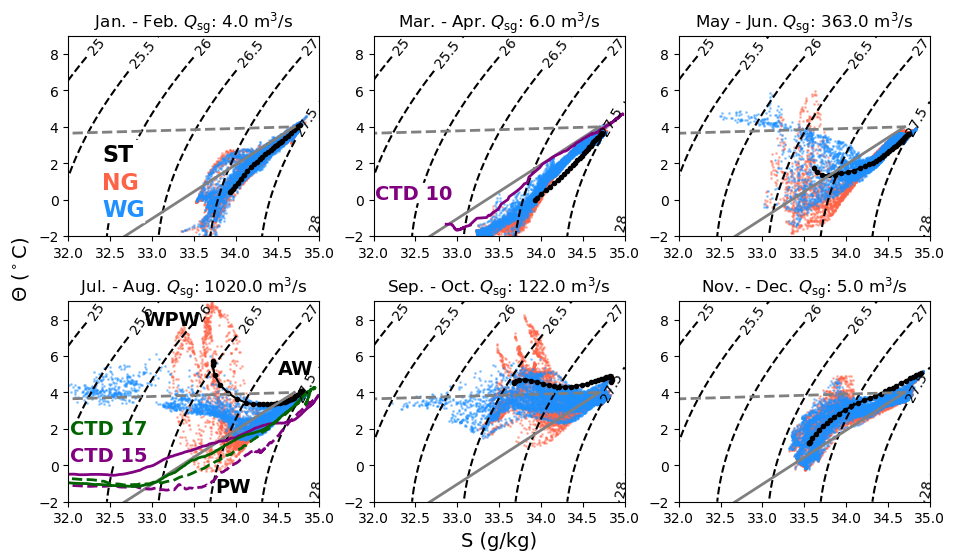

In [63]:

title_list = [['Jan. - Feb.','Mar. - Apr.','May - Jun.'],['Jul. - Aug.','Sep. - Oct.','Nov. - Dec.']]
month_list = [31,28,31,30,31,30,31,31,30,31,30,31]
saltg = np.linspace(32,35,100)
tempg = np.linspace(-2,9,100)
SS,TT = np.meshgrid(saltg,tempg)
densg = gsw.rho(SS,TT,0)-1000


s1= 1
fig, (ax) = plt.subplots(nrows=2,ncols=3,figsize=(10, 6))
fig.add_subplot(111, frameon=False)
k = 1



s_ind = [0,2,4,6,8,10,12]

for i in range(2):
    for j in range(3):
        if k == 6:
            a1 = dt.datetime(2015,11,1)
            b1 = dt.datetime(2015,12,31)
            a2 = dt.datetime(2016,11,1)
            b2 = dt.datetime(2016,12,31)
            a3 = dt.datetime(2017,11,1)
            b3 = dt.datetime(2017,12,31)    
        else:
            a1 = dt.datetime(2015,2*k-1,1)
            b1 = dt.datetime(2015,2*k+1,1)
            a2 = dt.datetime(2016,2*k-1,1)
            b2 = dt.datetime(2016,2*k+1,1)
            a3 = dt.datetime(2017,2*k-1,1)
            b3 = dt.datetime(2017,2*k+1,1)   
        D1 = len(Qsg.Qsg.sel(time=slice(a1,b1)))
        D2 = len(Qsg.Qsg.sel(time=slice(a2,b2)))
        D3 = len(Qsg.Qsg.sel(time=slice(a3,b3)))
        Dtot = D1+D2+D3
        
        if D1 < 3:
            Qsg_mon  = Qsg.Qsg.sel(time=slice(a2,b2)).mean('time').values*D2/Dtot+Qsg.Qsg.sel(time=slice(a3,b3)).mean('time').values*D3/Dtot
        else:
            Qsg_mon  = Qsg.Qsg.sel(time=slice(a1,b1)).mean('time').values*D1/Dtot+Qsg.Qsg.sel(time=slice(a2,b2)).mean('time').values*D2/Dtot+Qsg.Qsg.sel(time=slice(a3,b3)).mean('time').values*D3/Dtot

        k += 1
        im1 = ax[i,j].scatter(SF_ni.Salt.sel(T=slice(a1,b1)).mean('X'),SF_ni.Temp.sel(T=slice(a1,b1)).mean('X'),s=s1,color='tomato',alpha=.4)
        im2 = ax[i,j].scatter(SF_ni.Salt.sel(T=slice(a2,b2)).mean('X'),SF_ni.Temp.sel(T=slice(a2,b2)).mean('X'),s=s1,color='tomato',alpha=.4)
        im3 = ax[i,j].scatter(SF_ni.Salt.sel(T=slice(a3,b3)).mean('X'),SF_ni.Temp.sel(T=slice(a3,b3)).mean('X'),s=s1,color='tomato',alpha=.4)
        
        im4 = ax[i,j].scatter(SF_ip.Salt.sel(T=slice(a1,b1)).mean('X'),SF_ip.Temp.sel(T=slice(a1,b1)).mean('X'),s=s1,color='dodgerblue',alpha=.4)
        im5 = ax[i,j].scatter(SF_ip.Salt.sel(T=slice(a2,b2)).mean('X'),SF_ip.Temp.sel(T=slice(a2,b2)).mean('X'),s=s1,color='dodgerblue',alpha=.4)
        im6 = ax[i,j].scatter(SF_ip.Salt.sel(T=slice(a3,b3)).mean('X'),SF_ip.Temp.sel(T=slice(a3,b3)).mean('X'),s=s1,color='dodgerblue',alpha=.4)
        
        s_mid_m = shelf.Salt[s_ind[k-2]:s_ind[k-1],:].mean('T')
        t_mid_m = shelf.Temp[s_ind[k-2]:s_ind[k-1],:].mean('T')
        t_mid_mnan = np.where(s_mid_m > 0,t_mid_m,np.nan)
        s_mid_mnan = np.where(s_mid_m > 0,s_mid_m,np.nan)
        im7 = ax[i,j].plot(s_mid_mnan,t_mid_mnan,'k',marker='.')
        #ax[0,0].quiver(state1_mid.X[::10],state1_mid.Y[::10],uvel_plan_shallow1[::10, ::10], vvel_plan_shallow1[::10,::10], scale=5)
        CS1 = ax[i,j].contour(saltg,tempg,densg,levels=[25,25.5,26,26.5,27,27.5,28],colors='k',linestyles='--')
        fmt = {}
        strs = ['25','25.5','26','26.5','27','27.5','28']# labels added to the contours
        for l,s in zip(CS1.levels,strs):
            fmt[l] = s
        #label the levels with strings
        ax[i,j].clabel(CS1,levels=CS1.levels,fmt=fmt,fontsize=10)

        ax[i,j].set_ylim(-2,9)
        ax[i,j].set_xlim(32,35)
        ax[i,j].plot([4,34.7],[0,4], color='gray', linestyle='--', linewidth=2) # runoff line
        ax[i,j].plot([4,34.7],[-87,4], color='gray', linestyle='-', linewidth=2) # melt line
        #ax[i,j].plot([0,34],[0,gsw.CT_freezing(34,0,0)], color='gray', linestyle='-', linewidth=2) # freezing line
        ax[i,j].set_title(title_list[i][j]+' $Q_{\mathrm{sg}}$: '+str(np.round(Qsg_mon,0))+' m$^3$/s')

#plot ctds
ax[1,0].plot(CTD15.sal.isel(cast_num=slice(3,23)).mean('cast_num'),CTD15.temp.isel(cast_num=slice(3,23)).mean('cast_num'),color='purple',linewidth=2)
ax[1,0].plot(CTD15.sal.isel(cast_num=slice(23,34)).mean('cast_num'),CTD15.temp.isel(cast_num=slice(23,34)).mean('cast_num'),color='purple',linewidth=2,linestyle='--')
ax[1,0].plot(CTD17.sal.isel(cast_num=slice(0,14)).mean('cast_num'),CTD17.temp.isel(cast_num=slice(0,14)).mean('cast_num'),color='darkgreen',linewidth=2)
ax[1,0].plot(CTD17.sal.isel(cast_num=slice(14,24)).mean('cast_num'),CTD17.temp.isel(cast_num=slice(14,24)).mean('cast_num'),color='darkgreen',linewidth=2,linestyle='--')
ax[0,1].plot(CTD10.sal,CTD10.temp,color='purple',linewidth=2)

#patch for text
import matplotlib.patches as patches
rect = patches.Rectangle((32.3, -1.2), .6, 4.5, linewidth=1, edgecolor='white', facecolor='white',zorder=2)
rect2 = patches.Rectangle((32.02, -.1), 1, 1, linewidth=1, edgecolor='white', facecolor='white',zorder=2)
rect3 = patches.Rectangle((32, 0.1), .75, 2.3, linewidth=1, edgecolor='white', facecolor='white',zorder=2)
ax[0,0].add_patch(rect)
ax[0,1].add_patch(rect2)
ax[1,0].add_patch(rect3)
#text
ax[0,0].text(32.4,.6,'NG',color='tomato',fontsize=16,weight='bold')
ax[0,0].text(32.4,-.9,'WG',color='dodgerblue',fontsize=16,weight='bold')
ax[0,0].text(32.4,2.1,'ST',color='k',fontsize=16,weight='bold')
ax[1,0].text(33.75,-1.5,'PW',color='k',fontsize=14,weight='bold')
ax[1,0].text(34.5,5,'AW',color='k',fontsize=14,weight='bold')
ax[1,0].text(32.9,7.7,'WPW',color='k',fontsize=14,weight='bold')
ax[0,1].text(32.02,0,'CTD 10',color='purple',fontsize=14,weight='bold')
ax[1,0].text(32.02,0.2,'CTD 15',color='purple',fontsize=14,weight='bold')
ax[1,0].text(32.02,1.7,'CTD 17',color='darkgreen',fontsize=14,weight='bold')


plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('S (g/kg)', fontsize=14)
plt.ylabel('$\Theta$ ($^\circ$C)',fontsize=14)
plt.tight_layout()      
plt.savefig('Figs/TS_seasonal.png')

## Figure 11

In [ ]:
#datasets for figure 11
SF_tef_ni = xr.open_dataset(path_for_data+'Fig11/SF_3_tef_ni.nc')
SF_tef_ip = xr.open_dataset(path_for_data+'Fig11/SF_3_tef_ip.nc')

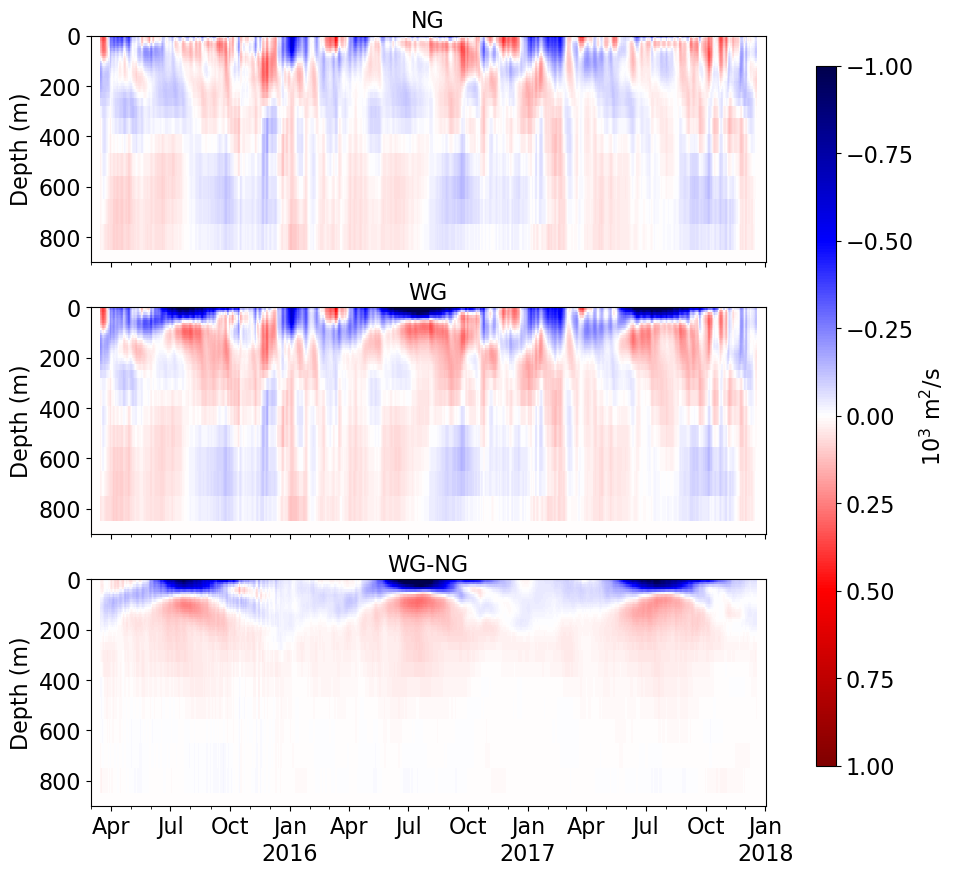

In [69]:

dateticks = ['2015-05','2015-09','2016-01','2016-05','2016-09','2017-01','2017-05','2017-09','2018-01']
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
ax = ax.ravel()

vmax = 15




Q_eu_ni = (SF_tef_ni.Vol.rolling(T=30, center=True).mean()).sum('X').transpose()
Q_eu_ip = (SF_tef_ip.Vol.rolling(T=30, center=True).mean()).sum('X').transpose()



pcol1 = ax[0].pcolormesh(SF_tef_ni.T,
                        -Q_eu_ni.Z,
                        Q_eu_ni/1000/np.transpose(matlib.repmat(grid.drF.values,1039,1)),
                        cmap='seismic',
                        vmin= -1,
                        vmax=1)
                       
#fig.colorbar(pcol1, ax=ax[0], orientation='vertical',label='10$^3$ m$^2$/s')
ax[0].set_ylim(900,0) #invert salinity axis
ax[0].set_ylabel('Depth (m)',fontsize=16)
#ax[0].grid()
#plt.colorbar(pcol,
             #ax=ax[0],
             #label='q / 10$^6$ m3 s-1 (g/kg)-1')
pcol = ax[1].pcolormesh(SF_tef_ip.T,
                        -SF_tef_ip.Z,
                        Q_eu_ip.values/1000/np.transpose(matlib.repmat(np.transpose(grid.drF.values),1039,1)),
                        cmap='seismic',
                        vmin= -1,
                        vmax=1)
                       
ax[1].set_ylabel('Depth (m)',fontsize=16)
#ax[1].grid()
ax[1].set_ylim(900,0)
locator = mdates.MonthLocator(bymonth=np.arange(1,12,3))
ax[1].xaxis.set_major_locator(locator)
min_loc = mdates.MonthLocator()
ax[1].xaxis.set_minor_locator(min_loc)

pcol = ax[2].pcolormesh(SF_tef_ip.T,
                        -SF_tef_ip.Z,
                        (Q_eu_ip.values-Q_eu_ni.values)/1000/np.transpose(matlib.repmat(np.transpose(grid.drF.values),1039,1)),
                        cmap='seismic',
                        vmin= -1,
                        vmax=1)
                       
ax[2].set_ylabel('Depth (m)',fontsize=16)
#ax[1].grid()
ax[2].set_ylim(900,0)
ax[0].set_title('NG',fontsize=16,color='black')
ax[1].set_title('WG',fontsize=16,color='black')
ax[2].set_title('WG-NG',fontsize=16,color='black')
locator = mdates.MonthLocator(bymonth=np.arange(1,12,3))
ax[2].xaxis.set_major_locator(locator)
min_loc = mdates.MonthLocator()
ax[2].xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

formatter = mdates.ConciseDateFormatter(locator, zero_formats=zfmts, show_offset=False)
#formatter = mdates.DateFormatter('%b')
ax[2].xaxis.set_major_formatter(formatter)
ax[1].tick_params('y', labelsize=16)
ax[2].tick_params('y', labelsize=16)
ax[2].tick_params('x', labelsize=16)
ax[0].tick_params('y', labelsize=16)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#plt.tight_layout()
cb = fig.colorbar(pcol, cax=cbar_ax,label='10$^3$ m$^2$/s')
cb.ax.tick_params(labelsize=16)
cb.ax.invert_yaxis() 
text = cb.ax.yaxis.label
font = matplotlib.font_manager.FontProperties( size=16)
text.set_font_properties(font)
plt.savefig('Figs/Hovemuller_transport.png')


## Figure 12

In [66]:
#datsets for figure 12
out1d_vol_transport_d = xr.open_dataset(path_for_data+'Fig12/out1d_vol_transport_d_ni.nc')
out1d_vol_transport_d_ip = xr.open_dataset(path_for_data+'Fig12/out1d_vol_transport_d_ip.nc')

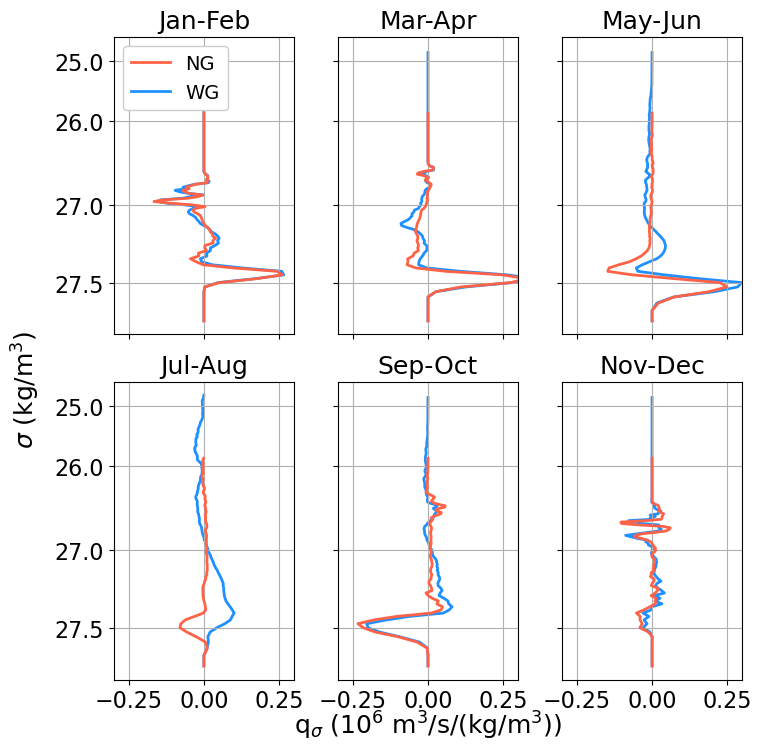

In [70]:
low_ni = out1d_vol_transport_d.q.rolling(time=30,center=True).mean()
low_ip = out1d_vol_transport_d_ip.q.rolling(time=30,center=True).mean()
#low_ni_hf = out1d_vol_transport_d_ip_hf.q.rolling(time=30,center=True).mean()


title_list = [['Jan-Feb','Mar-Apr','May-Jun'],['Jul-Aug','Sep-Oct','Nov-Dec']]
color_list = [['k','k','k'],['k','k','k']]
month_list = [31,28,31,30,31,30,31,31,30,31,30,31]

s = 1
fig, (ax) = plt.subplots(nrows=2,ncols=3,sharey=True,sharex=True,figsize=(8*s, 8*s))
fig.add_subplot(111, frameon=False)
k = -1




k = 1
for i in range(2):
    for j in range(3):
        #if i == 1:
            #ax[i,j].set_xlabel('q / 10$^6$ m3 s-1 (kg/m$^3$)-1')
        #if j == 0:
            #ax[i,j].set_ylabel('$\sigma$ (kg/m$^3$)')
        if k == 11:
            a1 = dt.datetime(2015,11,1)
            b1 = dt.datetime(2015,12,31)
            a2 = dt.datetime(2016,11,1)
            b2 = dt.datetime(2016,12,31)
            a3 = dt.datetime(2017,11,1)
            b3 = dt.datetime(2017,12,31)    
        else:
            a1 = dt.datetime(2015,k,1)
            b1 = dt.datetime(2015,k+2,1)
            a2 = dt.datetime(2016,k,1)
            b2 = dt.datetime(2016,k+2,1)
            a3 = dt.datetime(2017,k,1)
            b3 = dt.datetime(2017,k+2,1)   
        D1 = len(low_ni.sel(time=slice(a1,b1)))
        D2 = len(low_ni.sel(time=slice(a2,b2)))
        D3 = len(low_ni.sel(time=slice(a3,b3)))
        if D1 < 20:
            D1 = 0
            q_ni = 0
            q_ip = 0
            q_ni_hf = 0
        else:
            q_ni = low_ni.sel(time=slice(a1,b1)).mean('time')
            q_ip = low_ip.sel(time=slice(a1,b1)).mean('time')
            #q_ni_hf = low_ni_hf.sel(time=slice(a1,b1)).mean('time')
        Dtot = D1+D2+D3
        k += 2
        Z = convert_rho_z(out1d_vol_transport_d.var_q)
        #Z =(out1d_vol_transport_d.var_q)
        
        var_ni = q_ni*D1/Dtot + low_ni.sel(time=slice(a2,b2)).mean('time')*D2/Dtot+low_ni.sel(time=slice(a3,b3)).mean('time')*D3/Dtot
        var_ip = q_ip*D1/Dtot+low_ip.sel(time=slice(a2,b2)).mean('time')*D2/Dtot+low_ip.sel(time=slice(a3,b3)).mean('time')*D3/Dtot
        var_ni_r = var_ni.rolling(var_q=3,center=True).mean()
        var_ip_r = var_ip.rolling(var_q=3,center=True).mean()
        var_ni_hf = q_ni_hf
        p1, = ax[i,j].plot(var_ni_r.where(var_ni_r != 0)/1000000,Z,color='tomato',linewidth=2,zorder=2,label='NG')
        p2, = ax[i,j].plot(var_ip_r.where(var_ip_r != 0)/1000000,Z,color='dodgerblue',linewidth=2,zorder=1,label='WG')
        #if i+j > 10:
            #p3, = ax[i,j].plot(var_ni_hf/1000000,Z,color='orange',linewidth=2,zorder=1,label='ni hf')
        #ax[i,j].set_ylim(-750,0)
        ax[i,j].set_xlim(-.3,.3)
        #ax[i,j].set_yscale('function', functions=(forward, inverse))
        
        ytick_list = convert_rho_z(np.array([25,26,27,27.5])+1000)
        #ytick_list = np.arange(0,1.1,.1)
        ytick_list2 = inverse_convert(ytick_list)
        ax[i,j].set_yticks(ytick_list)
        ax[i,j].set_yticklabels(np.round(ytick_list2-1000,2))
        ax[i,j].tick_params('both', labelsize=16)
        ax[i,j].set_title(title_list[i][j],color=color_list[i][j],fontsize=18)
        ax[i,j].grid()
ax[0,0].legend(frameon=True,fontsize=14,loc='upper left',framealpha=1)
#fig.text(0.5, 0.04, 'q$_{\sigma}$ (10$^6$ m$^3$/s/(kg/m$^3$))', ha='center',fontsize=18)
fig.text(0.04, 0.5, '$\sigma$ (kg/m$^3$)', va='center', rotation='vertical',fontsize=18)
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#plt.tight_layout()
#fig.colorbar(im1, cax=cbar_ax)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'q$_{\sigma}$ (10$^6$ m$^3$/s/(kg/m$^3$))', fontsize=18)
plt.ylabel(' ',fontsize=18)
plt.tight_layout()
plt.savefig('Figs/tef_clima.png')  

## Figure 13

In [72]:
#open datasetsets with 90-day lowpass applies
bulk_rho_d_ni_lp = xr.open_dataset(path_for_data+'Fig13/bulk_rho_d_ni_lp.nc')
bulk_vol_d_ni_lp = xr.open_dataset(path_for_data+'Fig13/bulk_vol_d_ni_lp.nc')


#calc Qin,Qout, Qin*Din, Qout*Dout where D is potential density 
Q_in_d_ni_lp = bulk_vol_d_ni_lp.Qin.sum(axis=1)
Q_out_d_ni_lp = bulk_vol_d_ni_lp.Qout.sum(axis=1)
Qd_out_ni_lp = bulk_rho_d_ni_lp.Qout.sum(axis=1)
Qd_in_ni_lp = bulk_rho_d_ni_lp.Qin.sum(axis=1)
d_in_ni_lp = Qd_in_ni_lp / Q_in_d_ni_lp
d_out_ni_lp= Qd_out_ni_lp / Q_out_d_ni_lp

drho_lp_tef = (d_in_ni_lp-d_out_ni_lp).fillna(0)

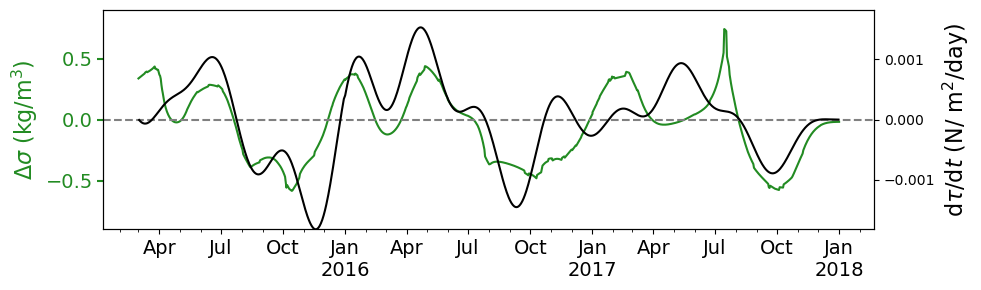

In [73]:

tkw = dict(size=4, width=1.5)
fig, ax2 = plt.subplots(1,1,sharex=True,figsize=(10,3))
twin1 = ax2.twinx()
p1, = ax2.plot(bulk_vol_d_ni_lp.time,drho_lp_tef,color='forestgreen',label=r'$\Delta \rho$')
ax2.axhline(y = 0, color = 'gray', linestyle = '--')
ax2.set_ylabel(r'$\Delta \sigma$ (kg/m$^{3}$)',fontsize=16)
ax2.set_ylim([-0.9,0.9])
ax2.yaxis.label.set_color(p1.get_color())
twin1.plot(surf.T[1:],dtau_lp_dx,color='k',label=r'd$\tau_{lp}$/d$t$')
ylim_max = np.max(abs(dtau_lp_dx))
twin1.set_ylabel(r'd$\tau$/d$t$ (N/ m$^2$/day)',fontsize=16)
twin1.set_ylim([-ylim_max,ylim_max])

ax2.tick_params(axis='y', colors=p1.get_color(), **tkw)
ax2.tick_params('y', labelsize=14) 
locator = mdates.MonthLocator(bymonth=np.arange(1,12,3))
ax2.xaxis.set_major_locator(locator)
min_loc = mdates.MonthLocator()
ax2.xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

formatter = mdates.ConciseDateFormatter(locator, zero_formats=zfmts, show_offset=False)
ax2.xaxis.set_major_formatter(formatter)
ax2.tick_params('x', labelsize=14)
ax2.tick_params('y', labelsize=14)
#ax2.legend(frameon=False)
plt.tight_layout()
plt.savefig('Figs/shelf_vs_drho_all_lp.png')

## Figure 14

In [79]:
#calc tef from the files
bulk_vol_d_ip = xr.open_dataset(path_for_data+'Fig14/bulk_vol_d_ip.nc')
Q_in_ni = bulk_vol_d_ni.Qin.sum(axis=1)
Q_out_ni = bulk_vol_d_ni.Qout.sum(axis=1)
Q_e_ni = (Q_in_ni-Q_out_ni)/2
Q_in_ip = bulk_vol_d_ip.Qin.sum(axis=1)
Q_out_ip = bulk_vol_d_ip.Qout.sum(axis=1)
Q_e_ip = (Q_in_ip-Q_out_ip)/2
dQ_p = Q_e_ip-Q_e_ni

bulk_vol_s_ni = xr.open_dataset(path_for_data+'Fig14/bulk_vol_s_ni.nc')
bulk_salt_s_ni = xr.open_dataset(path_for_data+'Fig14/bulk_salt_s_ni.nc')

bulk_vol_s_ip = xr.open_dataset(path_for_data+'Fig14/bulk_vol_s_ip.nc')
bulk_salt_s_ip = xr.open_dataset(path_for_data+'Fig14/bulk_salt_s_ip.nc')

bulk_vol_t_ni = xr.open_dataset(path_for_data+'Fig14/bulk_vol_t_ni.nc')
bulk_temp_t_ni = xr.open_dataset(path_for_data+'Fig14/bulk_temp_t_ni.nc')

bulk_vol_t_ip = xr.open_dataset(path_for_data+'Fig14/bulk_vol_t_ip.nc')
bulk_temp_t_ip = xr.open_dataset(path_for_data+'Fig14/bulk_temp_t_ip.nc')

bulk_rho_d_ni = xr.open_dataset(path_for_data+'Fig14/bulk_rho_d_ni.nc')
bulk_rho_d_ip = xr.open_dataset(path_for_data+'Fig14/bulk_rho_d_ip.nc')
bulk_vol_d_ni = xr.open_dataset(path_for_data+'Fig14/bulk_vol_d_ni.nc')
bulk_vol_d_ip= xr.open_dataset(path_for_data+'Fig14/bulk_vol_d_ip.nc')

Q_in_s_ni = bulk_vol_s_ni.Qin.sum(axis=1)
Q_out_s_ni = bulk_vol_s_ni.Qout.sum(axis=1)
Qs_out_ni = bulk_salt_s_ni.Qout.sum(axis=1)
Qs_in_ni= bulk_salt_s_ni.Qin.sum(axis=1)
s_in_ni= Qs_in_ni / Q_in_s_ni
s_out_ni= Qs_out_ni / Q_out_s_ni

Q_in_s_ip = bulk_vol_s_ip.Qin.sum(axis=1)
Q_out_s_ip = bulk_vol_s_ip.Qout.sum(axis=1)
Qs_out_ip = bulk_salt_s_ip.Qout.sum(axis=1)
Qs_in_ip = bulk_salt_s_ip.Qin.sum(axis=1)
s_in_ip = Qs_in_ip / Q_in_s_ip
s_out_ip= Qs_out_ip / Q_out_s_ip
# 
QedS_ni= (s_in_ni-s_out_ni)*(Q_in_s_ni-Q_out_s_ni)/2
QedS_ip = (s_in_ip-s_out_ip)*(Q_in_s_ip-Q_out_s_ip)/2

Q_in_t_ni = bulk_vol_t_ni.Qin.sum(axis=1)
Q_out_t_ni = bulk_vol_t_ni.Qout.sum(axis=1)
Qt_out_ni = bulk_temp_t_ni.Qout.sum(axis=1)
Qt_in_ni = bulk_temp_t_ni.Qin.sum(axis=1)
t_in_ni = Qt_in_ni / Q_in_t_ni
t_out_ni= Qt_out_ni / Q_out_t_ni

Q_in_t_ip = bulk_vol_t_ip.Qin.sum(axis=1)
Q_out_t_ip = bulk_vol_t_ip.Qout.sum(axis=1)
Qt_out_ip = bulk_temp_t_ip.Qout.sum(axis=1)
Qt_in_ip = bulk_temp_t_ip.Qin.sum(axis=1)
t_in_ip = Qt_in_ip / Q_in_t_ip
t_out_ip= Qt_out_ip / Q_out_t_ip
dT_ni = (t_in_ni-t_out_ni)
dT_ip = (t_in_ip-t_out_ip)

Q_e_ni_t = (Q_in_t_ni-Q_out_t_ni)/2
Q_e_ip_t = (Q_in_t_ip-Q_out_t_ip)/2
H_ni = Q_e_ni_t*dT_ni*1027*3850 # Watts
H_ip = Q_e_ip_t*dT_ip*1027*3850

Q_in_d_ni = bulk_vol_d_ni.Qin.sum(axis=1)
Q_out_d_ni = bulk_vol_d_ni.Qout.sum(axis=1)
Qd_out_ni = bulk_rho_d_ni.Qout.sum(axis=1)
Qd_in_ni = bulk_rho_d_ni.Qin.sum(axis=1)
d_in_ni = Qd_in_ni / Q_in_d_ni
d_out_ni= Qd_out_ni / Q_out_d_ni

Q_in_d_ip = bulk_vol_d_ip.Qin.sum(axis=1)
Q_out_d_ip = bulk_vol_d_ip.Qout.sum(axis=1)
Qd_out_ip = bulk_rho_d_ip.Qout.sum(axis=1)
Qd_in_ip = bulk_rho_d_ip.Qin.sum(axis=1)
d_in_ip = Qd_in_ip/ Q_in_d_ip
d_out_ip= Qd_out_ip / Q_out_d_ip

#dates of the summer
j_15 = 106
s_15 = 199
j_16 = 472
s_16 = 565
j_17 = 838
s_17 = 931


In [82]:
#this is all used to calculate th CTW theory
SF_CTW = xr.open_dataset(path_for_data+'Fig14/SF_CTW.nc')
SF_mth_c = xr.open_dataset(path_for_data+'Fig14/SF_mth_c.nc')
# Preliminaries


L = SF_CTW.L.values
W = SF_CTW.W.values
y = SF_CTW.y.values
L2 = L+W/2-y
f_cori = SF_CTW.f.values
rho_bar = SF_CTW.rho_bar.values
drho_dz = SF_CTW.drho_dz.values
h1 = 150  # Or should be 125 m?

# No need to high-pass filter rho_bar (but do need to remove mean)
eta = demean(rho_bar)/drho_dz

fs = 1/86400  # Sampling frequency (Hz) of the data in SF_CTW

# Define frequency vector that goes with FFT
Nt = eta.size
f = fs*np.r_[0:Nt/2+1]/Nt  
omega = 2*np.pi*f;

# Define range of c values to loop over
cs = np.r_[0.4:1.1:0.1]
Nc = cs.size

# Preallocate 2D matrix Q(c, t)
Q = np.zeros([Nt, Nc])

# Do the actual wave calculation
for ci, c in enumerate(cs):
    Rd = c/f_cori
    scale_factor = 2*c*Rd*(1 - np.exp(-W/Rd))
    tmp_fft = rfft(scale_factor*eta)*np.sin(omega*L2/c)
    Q[:, ci] = irfft(tmp_fft)

# For each time, interpolate to the model's wave speed 
t = np.r_[:Nt]
interpolator = RectBivariateSpline(t, cs, Q)
Q_vs_t = interpolator(t, SF_mth_c.c.values[15:-17], grid=False)

# Low-pass (30-day) the absolute value
Q_vs_t2 = np.abs(moving_average(Q_vs_t,30))

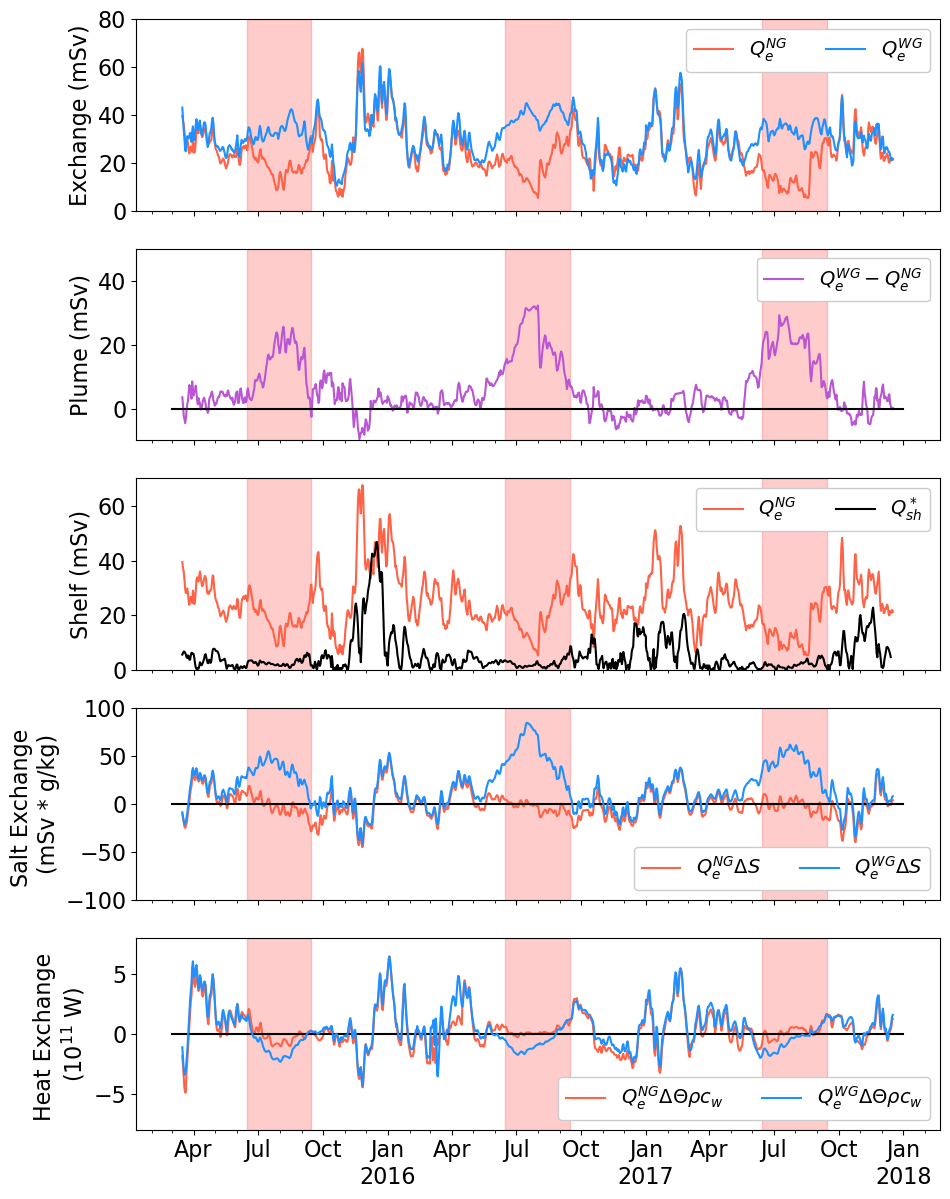

In [83]:

s = 1.2
index =[1,-1]

fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(ncols=1,nrows=5,sharex=True,figsize=(8*s,10*s))

ax1.plot(bulk_vol_d_ni.time[a:b],Q_e_ni[a:b]/(10**3),color='tomato',label='$Q_{e}^{NG}$')
ax1.plot(bulk_vol_d_ip.time[a:b],Q_e_ip[a:b]/(10**3),color='dodgerblue',label='$Q_{e}^{WG}$')
ax1.fill_between(bulk_vol_d_ni.time[j_15:s_15],0,80,color='r',alpha=.2)
ax1.fill_between(bulk_vol_d_ni.time[j_16:s_16],0,80,color='r',alpha=.2)
ax1.fill_between(bulk_vol_d_ni.time[j_17:s_17],0,80,color='r',alpha=.2)
ax1.set_ylabel('Exchange (mSv)',fontsize=16)
ax1.set_ylim(0,80)
ax1.legend(frameon=True,loc='upper right',fontsize=14,ncol = 2,facecolor='w',framealpha=1)


p1, = ax2.plot(bulk_vol_d_ni.time[a:b],dQ_p[a:b]/(10**3),label='$Q_{e}^{WG}-Q_{e}^{NG}$',color='mediumorchid',zorder=2)
ax2.plot(bulk_vol_d_ni.time[index],[0,0],color='k')
#ax2.tick_params(axis='y', colors=p1.get_color(), **tkw)
#ax2.yaxis.label.set_color(p1.get_color())
ax2.legend(frameon=True,loc='upper right',fontsize=14,ncol = 2,facecolor='w',framealpha=1)
ax2.fill_between(bulk_vol_d_ni.time[j_15:s_15],-10,50,color='r',alpha=.2)
ax2.fill_between(bulk_vol_d_ni.time[j_16:s_16],-10,50,color='r',alpha=.2)
ax2.fill_between(bulk_vol_d_ni.time[j_17:s_17],-10,50,color='r',alpha=.2)
ax2.set_ylim(-10,50)
ax2.set_ylabel('Plume (mSv)',fontsize=16)

ax3.plot(bulk_vol_d_ni.time[a:b],Q_e_ni[a:b]/(10**3),label='$Q_{e}^{NG}$',color='tomato',zorder=2)
ax3.plot(bulk_vol_d_ni.time[a:b-3],Q_vs_t2/1e3,color='k',label='$Q_{sh}^*$')
ax3.legend(frameon=True,loc='upper right',fontsize=14,ncol = 2,facecolor='w',framealpha=1)
ax3.fill_between(bulk_vol_d_ni.time[j_15:s_15],0,70,color='r',alpha=.2)
ax3.fill_between(bulk_vol_d_ni.time[j_16:s_16],0,70,color='r',alpha=.2)
ax3.fill_between(bulk_vol_d_ni.time[j_17:s_17],0,70,color='r',alpha=.2)
ax3.set_ylim(0,70)
ax3.set_ylabel('Shelf (mSv)',fontsize=16)

ax4.plot(bulk_vol_d_ni.time[a:b],QedS_ni[a:b]/(10**3),color='tomato',label='$Q_{e}^{NG}\Delta S$')
ax4.plot(bulk_vol_d_ni.time[index],[0,0],color='k')
ax4.plot(bulk_vol_d_ni.time[a:b],QedS_ip[a:b]/(10**3),color='dodgerblue',label='$Q_{e}^{WG}\Delta S$')
ax4.set_ylabel('Salt Exchange \n(mSv * g/kg)',fontsize=16)
ax4.fill_between(bulk_vol_d_ni.time[j_15:s_15],-100,100,color='r',alpha=.2)
ax4.fill_between(bulk_vol_d_ni.time[j_16:s_16],-100,100,color='r',alpha=.2)
ax4.fill_between(bulk_vol_d_ni.time[j_17:s_17],-100,100,color='r',alpha=.2)
ax4.set_ylim([-100,100])
ax4.legend(frameon=True,loc='lower right',fontsize=14,ncol=2,facecolor='w',framealpha=1)

ax5.plot(bulk_vol_d_ni.time[a:b],H_ni[a:b]/(10**11),color='tomato', label=r'$Q_{e}^{NG}\Delta \Theta \rho c_w$')
ax5.plot(bulk_vol_d_ni.time[index],[0,0],color='k')
ax5.plot(bulk_vol_d_ni.time[a:b],H_ip[a:b]/(10**11),label=r'$Q_{e}^{WG}\Delta \Theta \rho c_w$',color='dodgerblue',zorder=2 )
ax5.legend(frameon=True,fontsize=14,ncol = 2,facecolor='w',framealpha=1)
ax5.set_ylabel('Heat Exchange \n(10$^{11}$ W)',fontsize=16)
ax5.fill_between(bulk_vol_d_ni.time[j_15:s_15],-8,8,color='r',alpha=.2)
ax5.fill_between(bulk_vol_d_ni.time[j_16:s_16],-8,8,color='r',alpha=.2)
ax5.fill_between(bulk_vol_d_ni.time[j_17:s_17],-8,8,color='r',alpha=.2)
ax5.set_ylim([-8,8])

ax1.tick_params('y', labelsize=16)
ax2.tick_params('y', labelsize=16)
ax3.tick_params('y', labelsize=16)
ax4.tick_params('y', labelsize=16)
ax5.tick_params('x', labelsize=16)
ax5.tick_params('y', labelsize=16)

locator = mdates.MonthLocator(bymonth=np.arange(1,12,3))
ax5.xaxis.set_major_locator(locator)
min_loc = mdates.MonthLocator()
ax5.xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

formatter = mdates.ConciseDateFormatter(locator, zero_formats=zfmts, show_offset=False)
#formatter = mdates.DateFormatter('%b')
ax5.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.savefig('Figs/tef_bulk_fluxes.png')

## Figure 15

In [84]:
SF_tef_along_line = xr.open_dataset(path_for_data+'Fig15/SF_tef_line.nc')
Q_in_L = SF_tef_along_line.Qin
Q_out_L = SF_tef_along_line.Qout
Dist = SF_tef_along_line.L
vol_list = SF_tef_along_line.vol_list


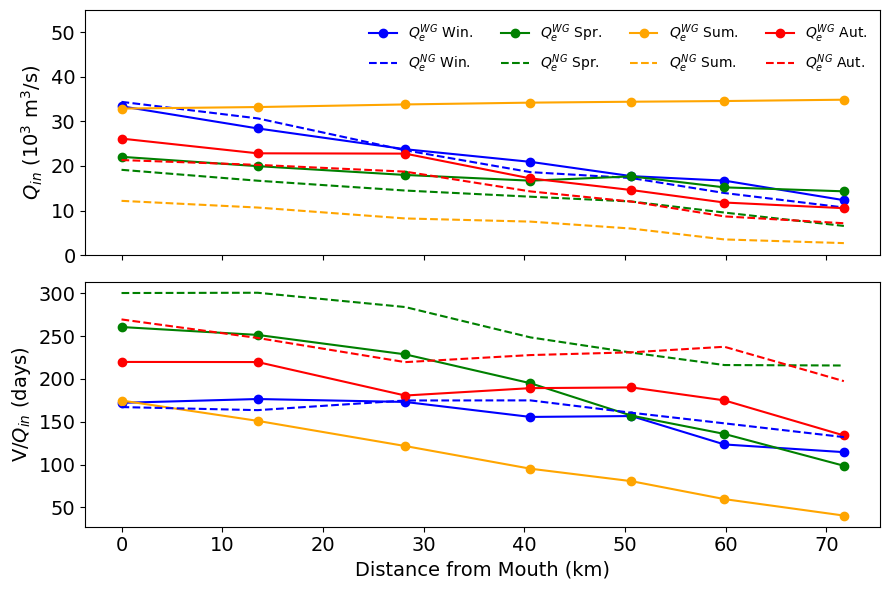

In [85]:



fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(9,6))
#plt.scatter(Along_fjord_distances, Sin_apr, color='red')
ax1.plot(Dist, (Q_in_L[:,0,1]-Q_out_L[:,0,1])/1000/2, color='blue', linestyle='-', marker='o', label='$Q_{e}^{WG}$ Win.')#win
ax1.plot(Dist, (Q_in_L[:,0,0]-Q_out_L[:,0,0])/1000/2, color='blue', linestyle='--', marker='', label='$Q_{e}^{NG}$ Win.')
ax1.plot(Dist, (Q_in_L[:,1,1]-Q_out_L[:,1,1])/1000/2, color='green', linestyle='-', marker='o',label='$Q_{e}^{WG}$ Spr.')#spr
ax1.plot(Dist, (Q_in_L[:,1,0]-Q_out_L[:,1,0])/1000/2, color='green', linestyle='--', marker='',label='$Q_{e}^{NG}$ Spr.')
ax1.plot(Dist, (Q_in_L[:,2,1]-Q_out_L[:,2,1])/1000/2, color='orange', linestyle='-', marker='o',label='$Q_{e}^{WG}$ Sum.')#sum
ax1.plot(Dist, (Q_in_L[:,2,0]-Q_out_L[:,2,0])/1000/2, color='orange', linestyle='--', marker='',label='$Q_{e}^{NG}$ Sum.')
ax1.plot(Dist, (Q_in_L[:,3,1]-Q_out_L[:,3,1])/1000/2, color='red', linestyle='-' ,marker='o',label='$Q_{e}^{WG}$ Aut.')#aut
ax1.plot(Dist, (Q_in_L[:,3,0]-Q_out_L[:,3,0])/1000/2, color='red', linestyle='--' ,marker='',label='$Q_{e}^{NG}$ Aut.')

#ax1.set_xlabel('Along Fjord Distance (km)', fontsize=14)
ax1.set_ylabel('$Q_{in}$ (10$^3$ m$^3$/s)', fontsize=14)
ax1.set_ylim([0,55])
#ax1.set_ylim(0,5)
ax1.legend(loc="upper right", ncol = 4,frameon=False)
ax1.tick_params('both', labelsize=14)

ax2.plot(Dist, vol_list/((Q_in_L[:,0,1]-Q_out_L[:,0,1])/2)/(86400), color='blue', linestyle='-', marker='o', label='$Q_{in}^{WG}$ Win.')
ax2.plot(Dist, vol_list/((Q_in_L[:,1,1]-Q_out_L[:,1,1])/2)/(86400), color='green', linestyle='-', marker='o',label='$Q_{in}^{WG}$ Spr.')
ax2.plot(Dist, vol_list/((Q_in_L[:,2,1]-Q_out_L[:,2,1])/2)/(86400), color='orange', linestyle='-', marker='o',label='$Q_{in}^{WG}$ Sum.')
ax2.plot(Dist, vol_list/((Q_in_L[:,3,1]-Q_out_L[:,3,1])/2)/(86400), color='red', linestyle='-', marker='o',label='$Q_{in}^{WG}$ Aut.')
ax2.plot(Dist, vol_list/((Q_in_L[:,0,0]-Q_out_L[:,0,0])/2)/(86400), color='blue', linestyle='--', marker='', label='$Q_{in}^{NG}$ Win.')
ax2.plot(Dist, vol_list/((Q_in_L[:,1,0]-Q_out_L[:,1,0])/2)/(86400), color='green', linestyle='--', marker='',label='$Q_{in}^{NG}$ Spr.')
ax2.plot(Dist, vol_list/((Q_in_L[:,3,0]-Q_out_L[:,3,0])/2)/(86400), color='red', linestyle='--', marker='',label='$Q_{in}^{NG}$ Aut.')
ax2.set_xlabel('Distance from Mouth (km)', fontsize=14)
ax2.set_ylabel('V/$Q_{in}$ (days)', fontsize=14)

ax2.tick_params('both', labelsize=14)
fig.tight_layout()
plt.savefig('Figs/Along_fjord_plot.png')